In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np

import scipy
from scipy import stats

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from umap import UMAP
from sklearn.metrics import pairwise_distances

from pathlib import Path

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

In [3]:
sns.set(font_scale=1.25, style="ticks", context="notebook", palette="tab10")

In [4]:
## create mouse map
nage=6 #number of age groups
nmice=16
keep_mice = [
    "_01_01",
    "_01_02",
    "_01_03",
    "_01_04",
    "_02_01",
    "_02_02",
    "_02_03",
    "_02_04",
    "_03_01",
    "_03_02",
    "_03_03",
    "_03_04",
    "_04_01",
    "_04_02",
    "_04_03",
    "_04_04",
] * nage
ages = np.repeat(['4','8','12','52','78','90'],nmice)
mouse_id = [x + y for x, y in zip(ages, keep_mice)]
samples = list(range(1,nage*nmice+1))
mapping = {key: value for key, value in zip(samples, mouse_id)}

In [5]:
## upload the raw beta file and sample table and ID

In [6]:
base_folder = Path("/n/groups/datta/win/longtogeny/data/epigenetics/analysis")

In [7]:
df_sample_mean = pd.read_csv(
    "/n/groups/datta/win/longtogeny/data/epigenetics/Datta_Project_001/Datta_Project_001/Datta_Project_001_Samples_Table.txt", sep="\t"
)

In [8]:
df = pd.read_csv(
    "/n/groups/datta/win/longtogeny/data/epigenetics/Datta_Project_001/Datta_Project_001/Datta_Project_001_Sample_Methylation_Profile.txt", sep="\t"
)

/tmp/ipykernel_928/4165350121.py:1: DtypeWarning: Columns (4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,38,40,42,44,46,48,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [9]:
df["target_type"] = df.TargetID.str[:2]
df_subset = df[df.target_type == "cg"].copy()

# uploads normalized and corrected betas from sesame script in R

In [10]:
# opload prediction of age from epigenetic clock zou 2022 as applied by sesame
df_age_pred = pd.read_csv(base_folder / "age_prediction.csv", index_col=0)
df_age_pred["weeks"] = df_age_pred["outs"] * 4
weeks = [4, 8, 12, 52, 78, 90]
array_week = np.array(weeks)

In [11]:
# upload normzlized and corrected beta values as calculated by r script sesame
df_beta = pd.read_csv(base_folder / "betas_mat.csv.gz", index_col=0)

In [12]:
# arrange data and run PCA
df_keep = df_beta[~df_beta.isnull().any(axis=1)]
X_mat = df_keep.values.T
print(X_mat.shape)

pca = PCA(n_components=20).fit(X_mat)
X_pca = pca.transform(X_mat)

(24, 275573)


In [13]:
#seperate the array name from the raw-column id. to be used later to map location on chip to mouse id
df_meta = pd.DataFrame(
    df_keep.columns.str.split("_").tolist(),
    columns=["array", "rc"],
    index=df_keep.columns,
)

In [14]:
# to map mouse id to location on plate
df_sample_mean.columns = df_sample_mean.columns.map(lambda l: l.replace(" ", "_"))
df_sample_mean["array"] = df_sample_mean["Sentrix_Barcode"].astype(str).copy()

In [15]:
# match mouse/sampel id to array location, add chronolocal age information
# df_meta_merge matches sample id with all kinds of meta data such as chip. r-c location and intensity measures.  
df_meta_merge = (
    df_meta.reset_index()
    .merge(
        df_sample_mean,
        left_on=["array", "rc"],
        right_on=["array", "Sample_Section"],
        how="left",
    )
    .set_index("index")
)
df_meta_merge["age"] = array_week[
    np.floor(((df_meta_merge["Index"] - 1) / 4)).astype(int)
]
df_meta_merge["age_cat"] = pd.Categorical(df_meta_merge.age, categories=weeks)

assert df_keep.columns.equals(df_meta_merge.index)

In [16]:
## add mouse identification to df_meta_merge
df_meta_merge['mouse_id'] = df_meta_merge['Sample_ID']
df_meta_merge['mouse_id'] = df_meta_merge['mouse_id'].map(mapping)
dna_meta = df_meta_merge[['age_cat','mouse_id','Sentrix_Barcode']]

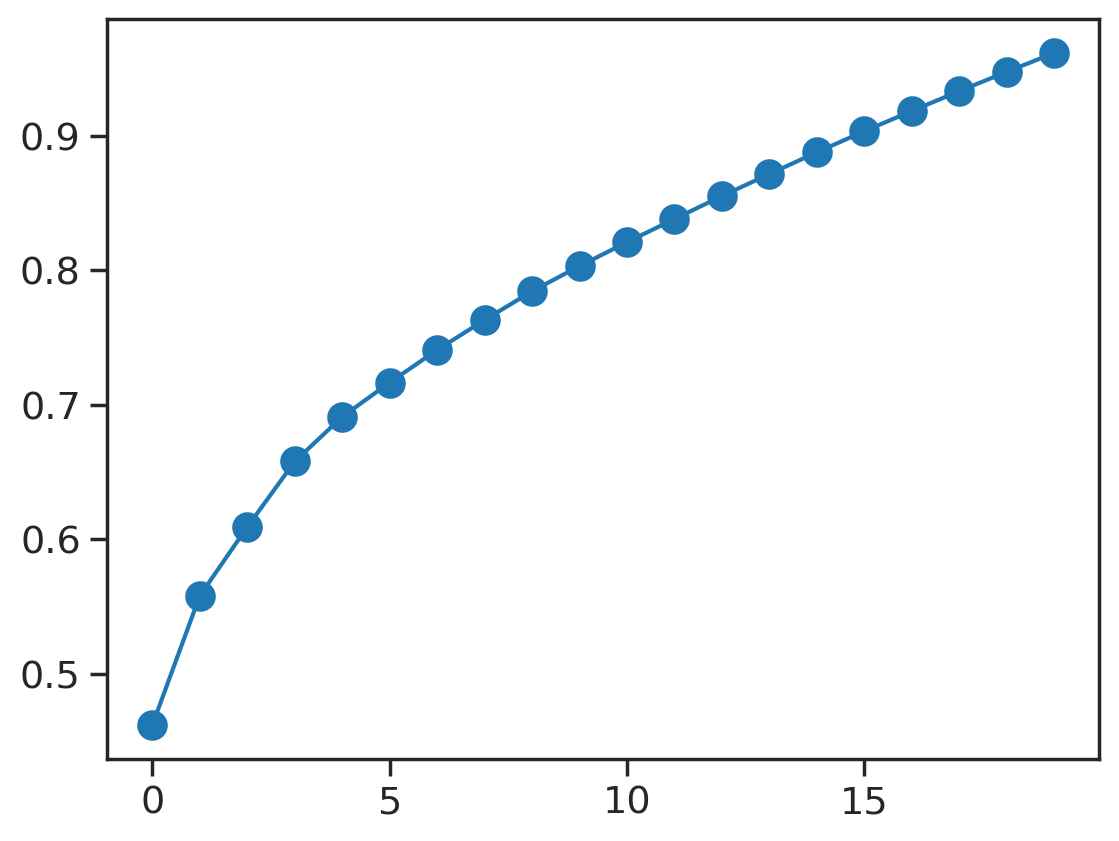

In [17]:
fig, ax = plt.subplots()
plt.plot(np.cumsum(pca.explained_variance_ratio_), '.-', ms=20)

In [18]:
df_pca = pd.DataFrame(X_pca, index=df_keep.columns)
#df_pca_merge = df_pca.join(df_meta_merge)
df_pca_merge = df_pca.join(dna_meta)

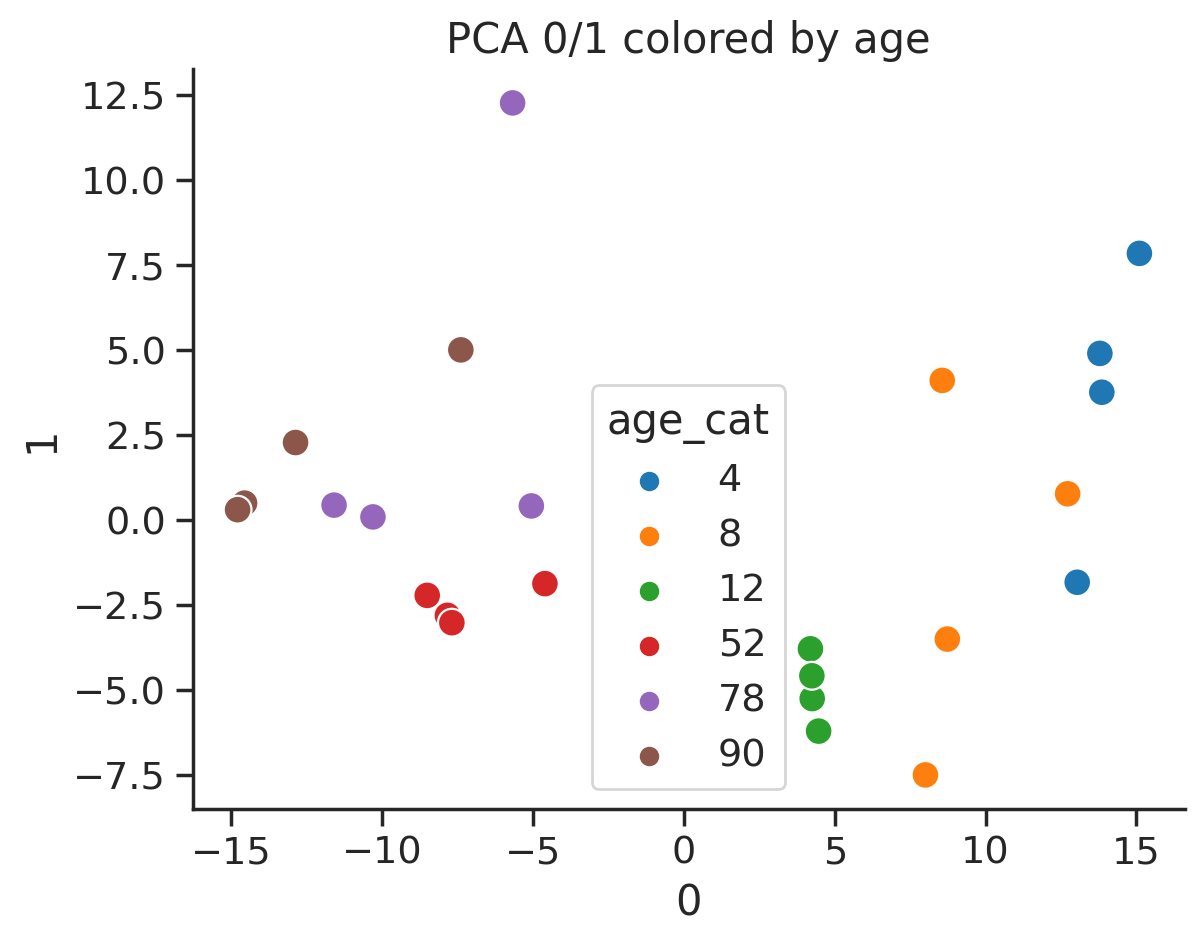

In [19]:
fig, ax = plt.subplots()
sns.scatterplot(df_pca_merge, x=0, y=1, hue="age_cat", s=100)
ax.set_title ('PCA 0/1 colored by age')
sns.despine()

In [20]:
# sort the label id by the actual age order
##IMPORATN! MAYBE ALSO SORT BY MOUSE id"
age_order = df_meta_merge.sort_values(['age_cat', 'Index']).index

In [21]:
df_pca_corr = df_pca.T[age_order].corr()

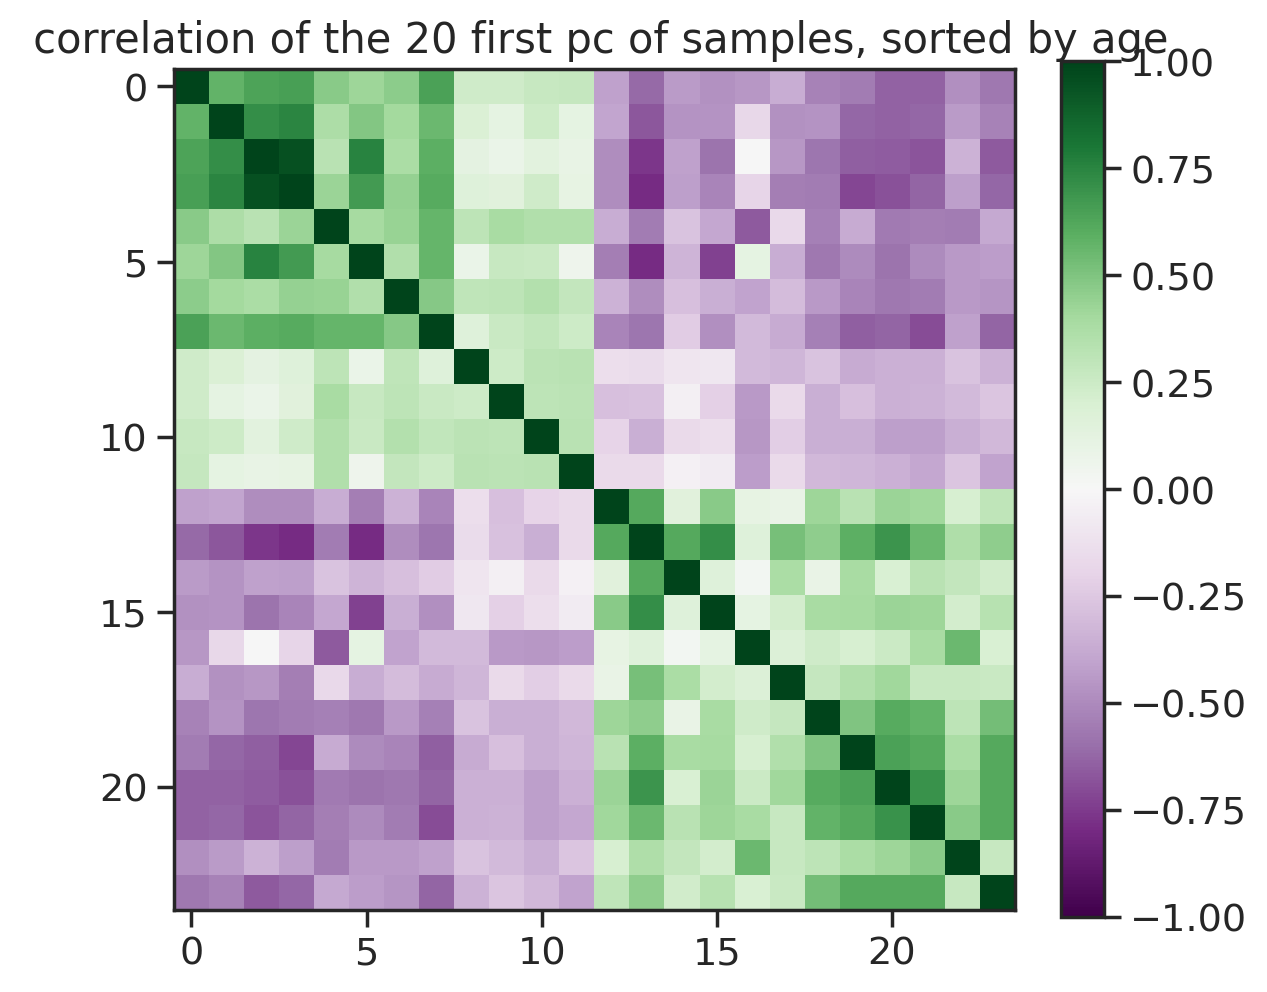

In [22]:
# plot the oc correlation between different mice, sorted by age order
df_pca_corr = df_pca.T[age_order].corr()
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(df_pca_corr, aspect="auto", vmin=-1, vmax=1, cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title (' correlation of the 20 first pc of samples, sorted by age')
plt.colorbar(im, fraction=0.046)

UMAP(min_dist=0.25, verbose=True)
Thu Feb 22 11:35:02 2024 Construct fuzzy simplicial set
Thu Feb 22 11:35:02 2024 Finding Nearest Neighbors
Thu Feb 22 11:35:05 2024 Finished Nearest Neighbor Search
Thu Feb 22 11:35:09 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Feb 22 11:35:11 2024 Finished embedding


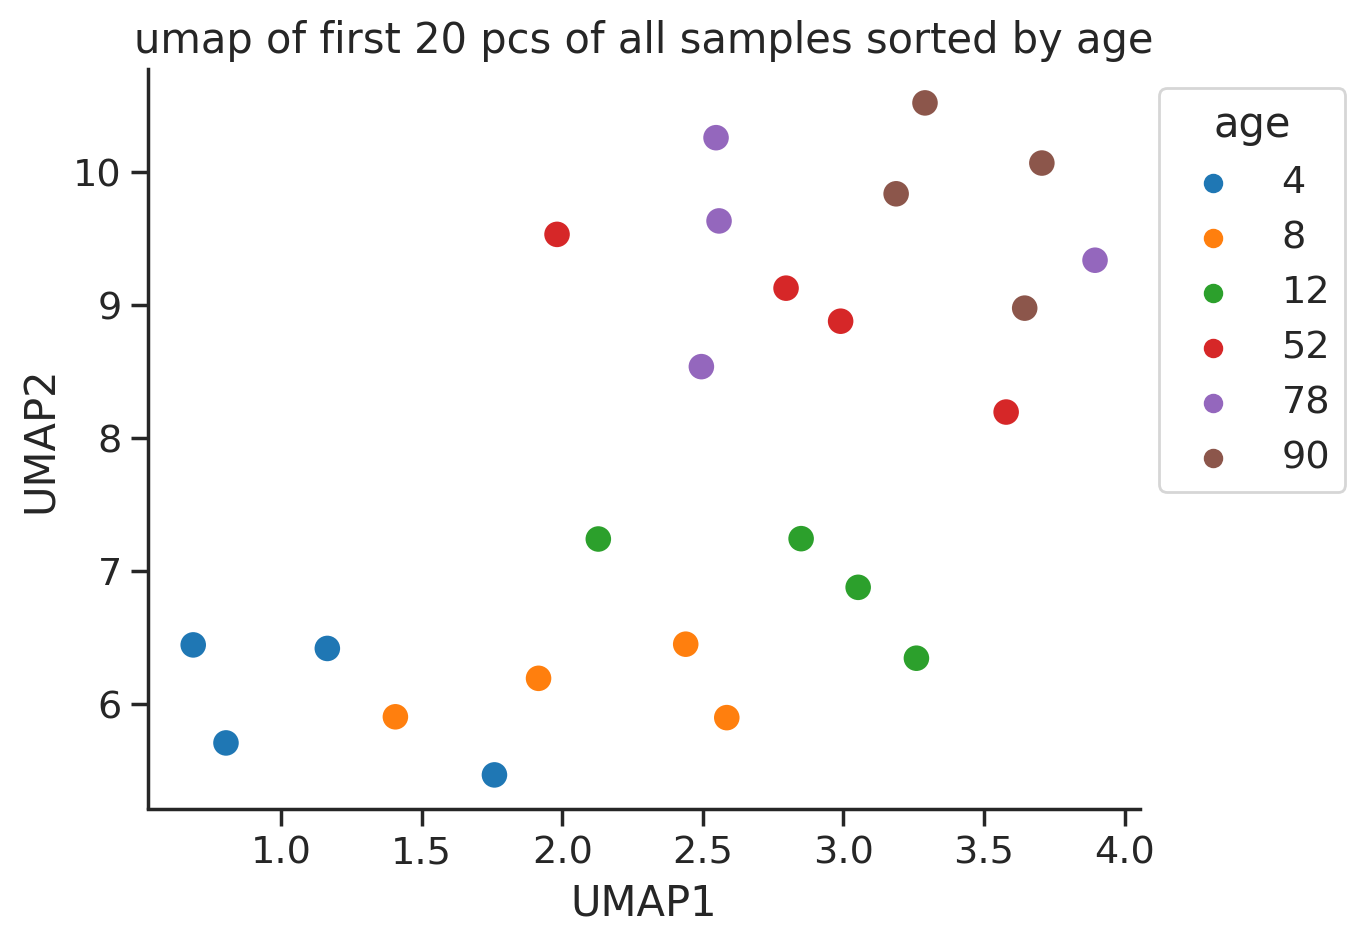

In [23]:
# also plot umap
X_umap = UMAP(n_components=2, min_dist=0.25, verbose=True).fit_transform(X_pca)
df_umap = pd.DataFrame(X_umap, index=df_keep.columns, columns=["UMAP1", "UMAP2"]).join(df_meta_merge)
fig, ax = plt.subplots()
sns.scatterplot(df_umap, x="UMAP1", y="UMAP2", hue="age_cat", s=100, ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), title="age")
ax.set_title ('umap of first 20 pcs of all samples sorted by age')
sns.despine()

In [24]:
## find the loads of the differentct pc's on the actual methyl sites

In [25]:
df_comp = pd.DataFrame(pca.components_.T, index=df_keep.index)

In [26]:
# to look for specific probes that have the highest loads on pc 0 
df_comp[0].sort_values()

cg29611121_TC21   -0.018319
cg29611138_TC21   -0.014766
cg46354352_BC11   -0.014482
cg44695870_BC11   -0.013263
cg48206202_TC11   -0.012653
                     ...   
cg30292048_TC11    0.024060
cg33754067_TC11    0.024134
cg35931402_TC11    0.024392
cg30224278_BC11    0.025822
cg33797913_TC11    0.031224
Name: 0, Length: 275573, dtype: float64

In [27]:
# find one specific probe in all of our samples
pr="cg28977202_TC11"
df_meta_probe = df_meta_merge.join(df_keep.loc[pr].rename("probe"))

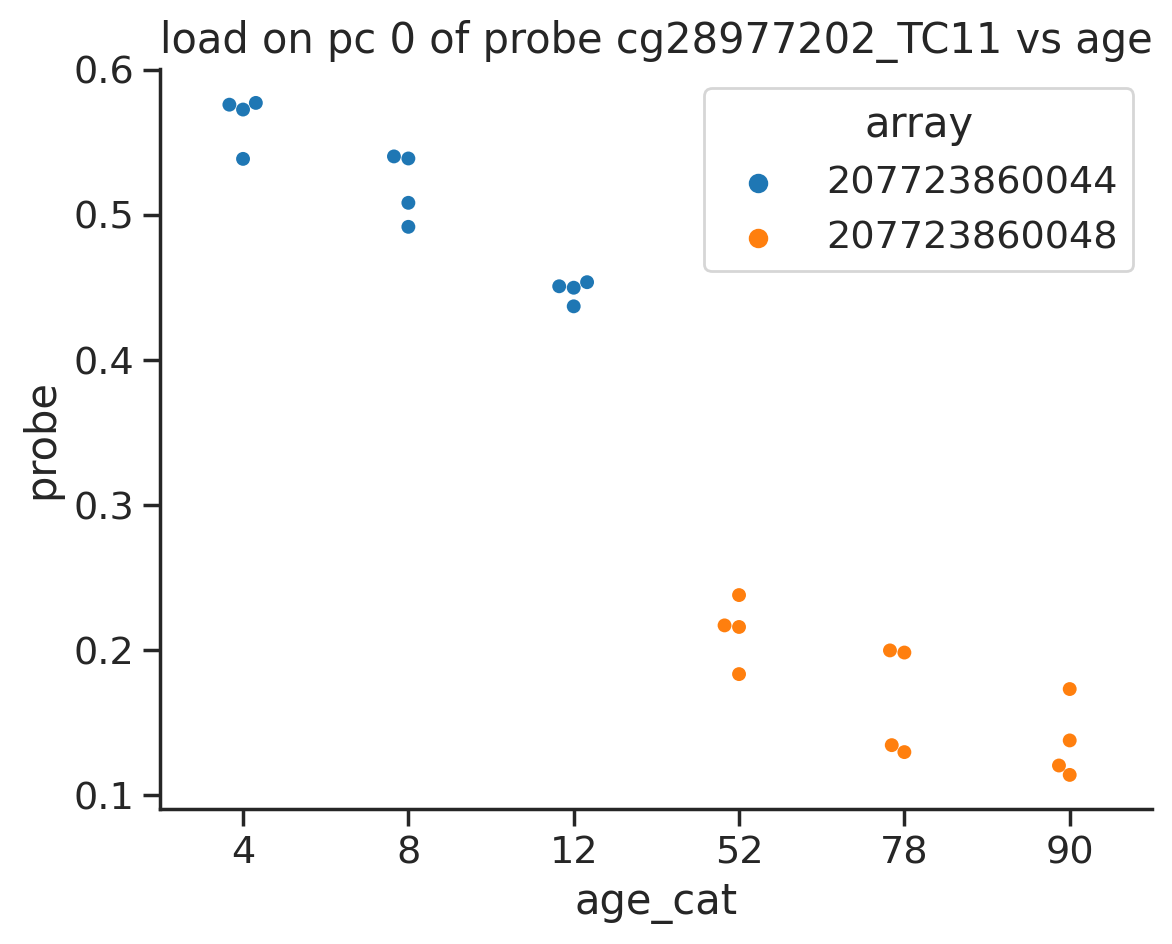

In [28]:
fig, ax = plt.subplots()
sns.swarmplot(data=df_meta_probe, x="age_cat", y="probe", hue="array")
ax.set_title('load on pc 0 of probe ' + pr + " vs age")
sns.despine()

In [29]:
## plot the loads of the 200 sites with the highest loads on pc 0 for the different samples

In [30]:
# find the 100 probes with the largerst loads on pc0 across all samples, avarage thier loads for each sample
df_probe_mean = df_keep.loc[df_comp[0].nlargest(100).index].mean().rename("probe")

In [31]:
# zscore the values from above and match to the age of the samples
df_probe_mean = (
    df_keep.loc[df_comp[0].nlargest(100).index]
    .T.apply(stats.zscore)
    .mean(1)
    .rename("probe")
)
df_meta_probe = df_meta_merge.join(df_probe_mean)

In [32]:
# make the colors to match the ages
week_map = dict(zip(weeks, plt.cm.tab10.colors))
df_anno = df_meta_merge.age.map(week_map)

In [33]:
# find the 200 sited with the abs(highest) load on pc 0 
top100 = df_comp[0].nlargest(100).index
bottom100 = df_comp[0].nsmallest(100).index
both = top100.append(bottom100)

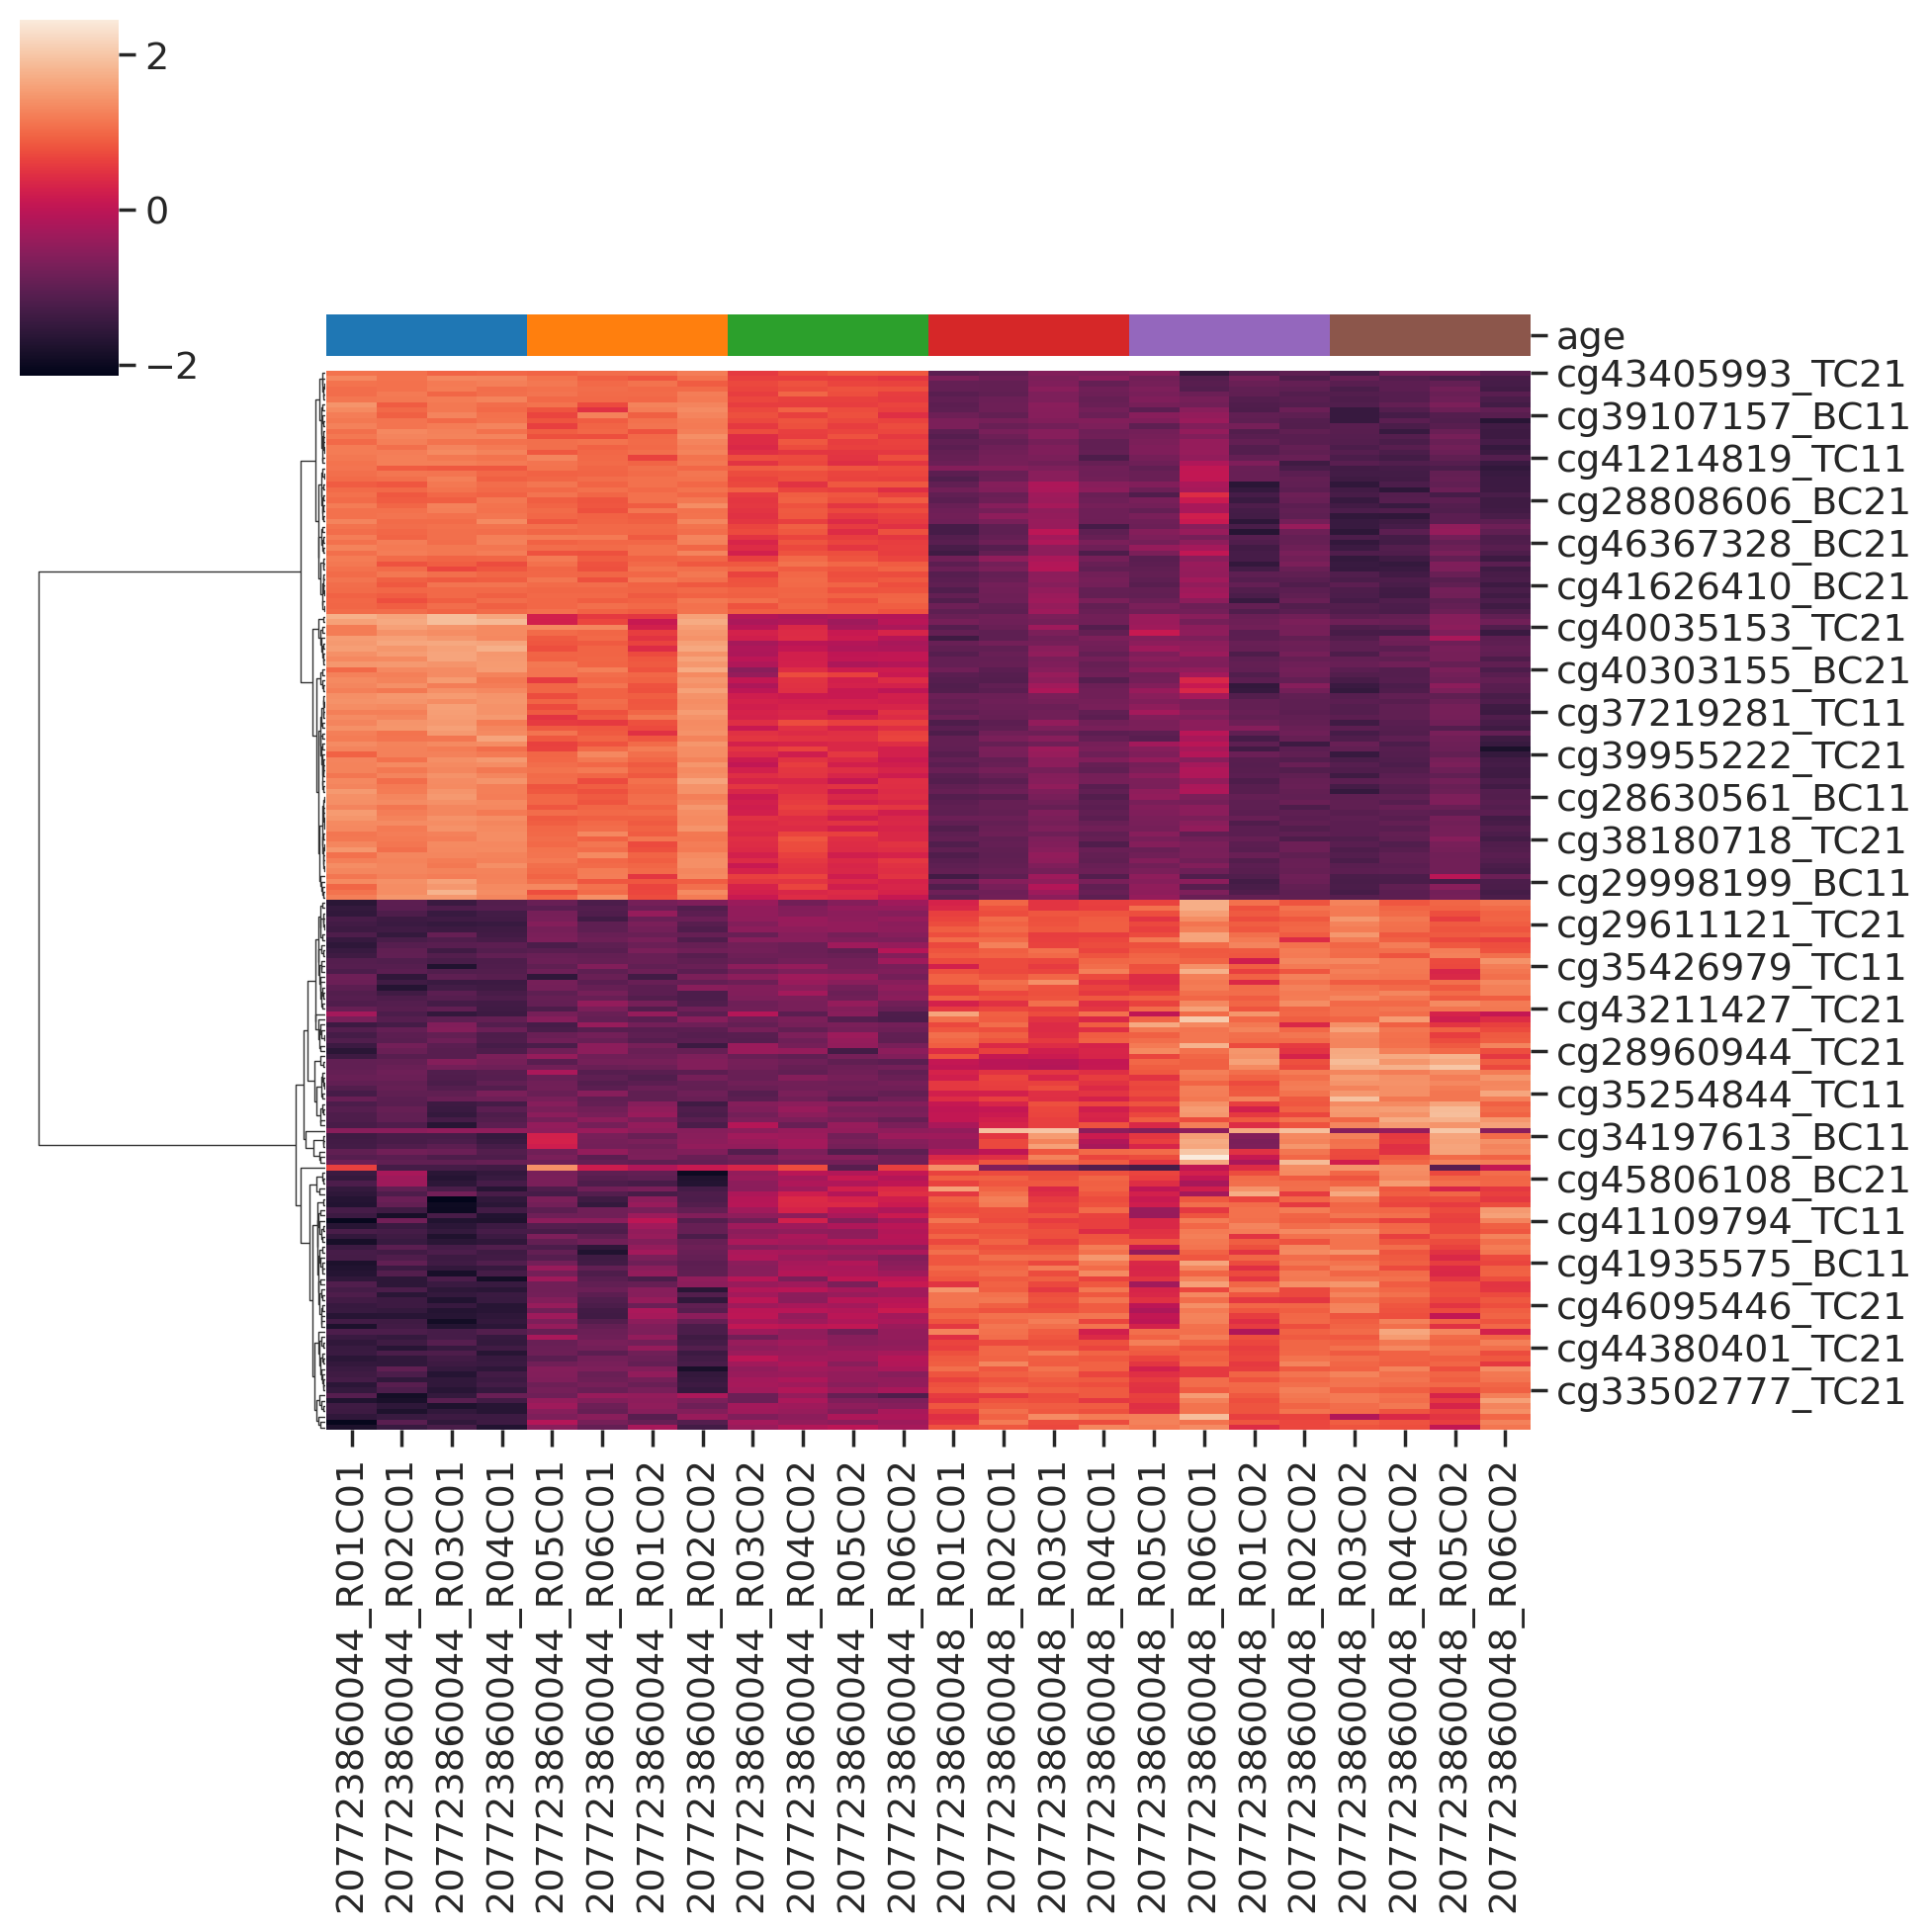

In [34]:
# plot loads for each of 200 sites for all samples
g = sns.clustermap(
    df_keep.loc[both][age_order],
    col_colors=df_anno,
    col_cluster=False,
    #row_cluster = False,
#     vmin=0, vmax=1,
    z_score=0,
    method="ward"
)

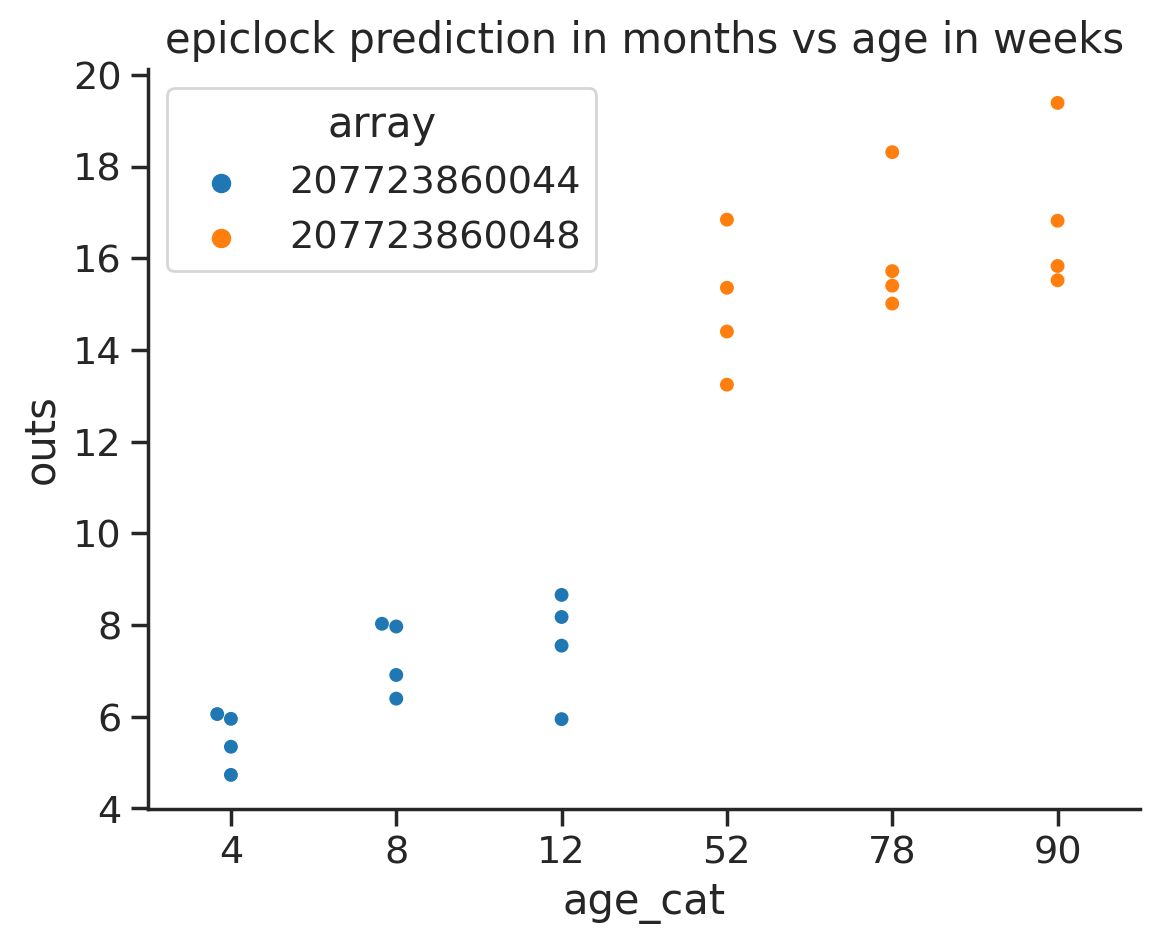

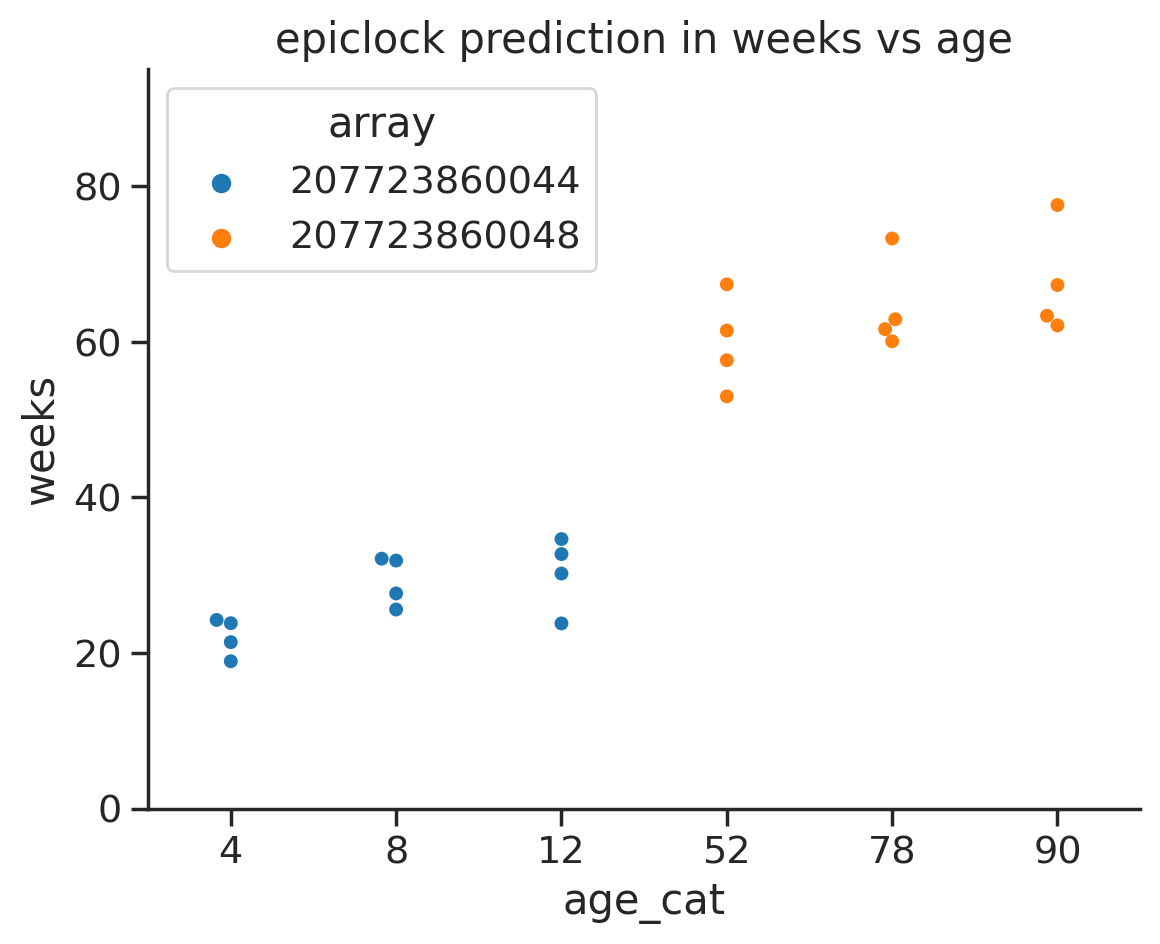

In [35]:
fig, ax = plt.subplots()
sns.swarmplot(data=df_age_pred.join(df_meta_merge), x="age_cat", y="outs", hue="array")
ax.set_title ('epiclock prediction in months vs age in weeks')
sns.despine()
fig, ax = plt.subplots()
sns.swarmplot(data=df_age_pred.join(df_meta_merge), x="age_cat", y="weeks", hue="array")
ax.set_title ('epiclock prediction in weeks vs age')
ax.set_ylim([0,95])
#ax.set_xlim([0,95])
sns.despine()

In [36]:
## compare with behavior

In [37]:
# load beahvioral data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

In [38]:
## update data
def filter_df(df):
    max=39
    n=16
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    df = df.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [39]:
# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','mouse','uuid']).mean()

In [40]:
#filter to find ages in age range of the epidata
fdata = data.reset_index()
fdata['mouse']=fdata['mouse'].str[-6:]
fdata['mouse_id'] = [x + y for x, y in zip(fdata['age'].astype(str), fdata['mouse'])]

In [41]:
# get just the mice who's id's are in the epigenetic samples
# get the pca matrix of the epigenetic data
df_pca_dna = df_pca_merge.copy()
df_pca_dna.set_index(['age_cat','mouse_id','Sentrix_Barcode'], inplace=True)
df_pca_dna.sort_index(inplace=True)
ids = df_pca_dna.index.get_level_values('mouse_id')

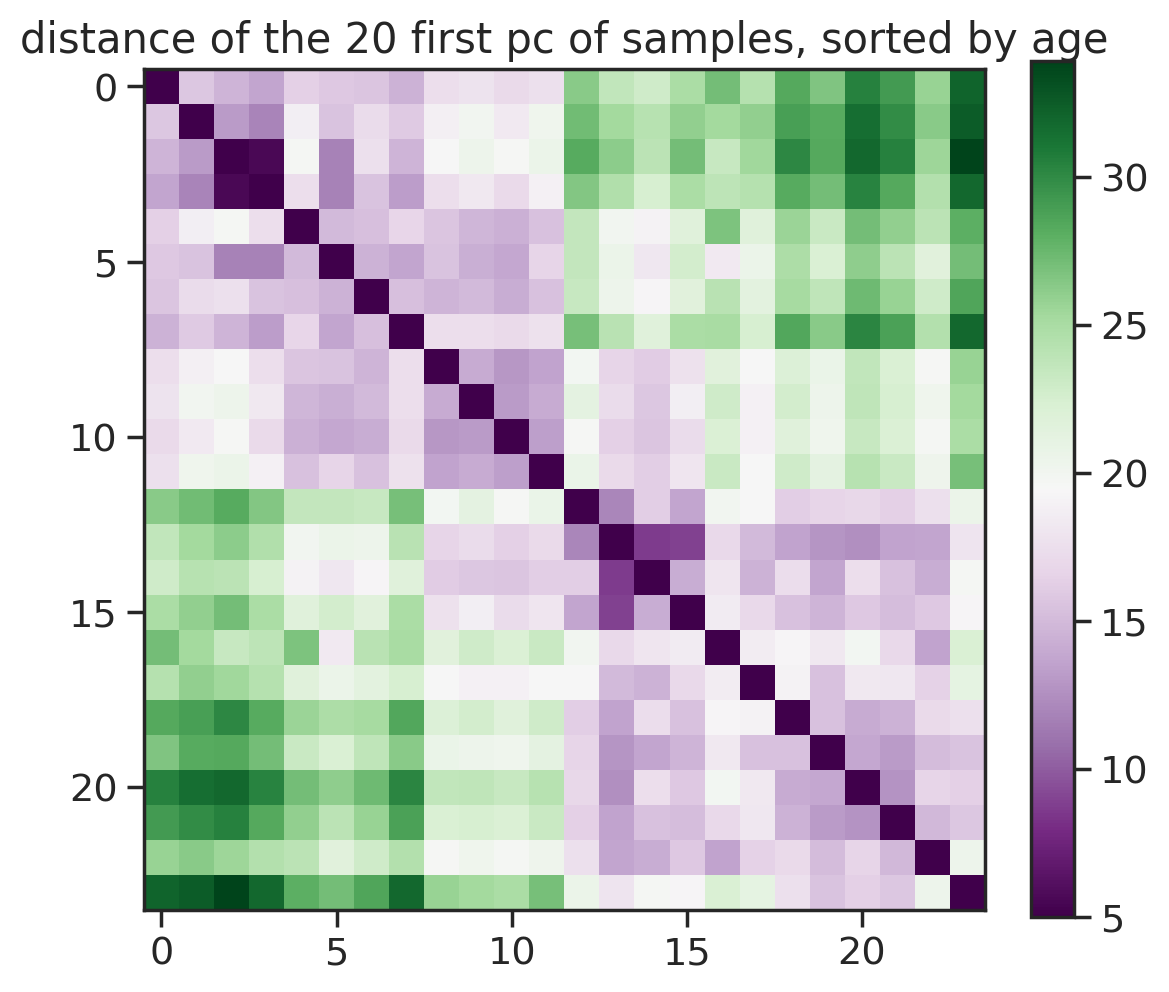

In [42]:
# plot the oc correlation between different mice, sorted by age order
dfd_pca_corr = pairwise_distances(df_pca_dna)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(dfd_pca_corr, aspect="auto", 
               vmin=5, 
               #vmax=1, 
               cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title ('distance of the 20 first pc of samples, sorted by age')
plt.colorbar(im, fraction=0.046)

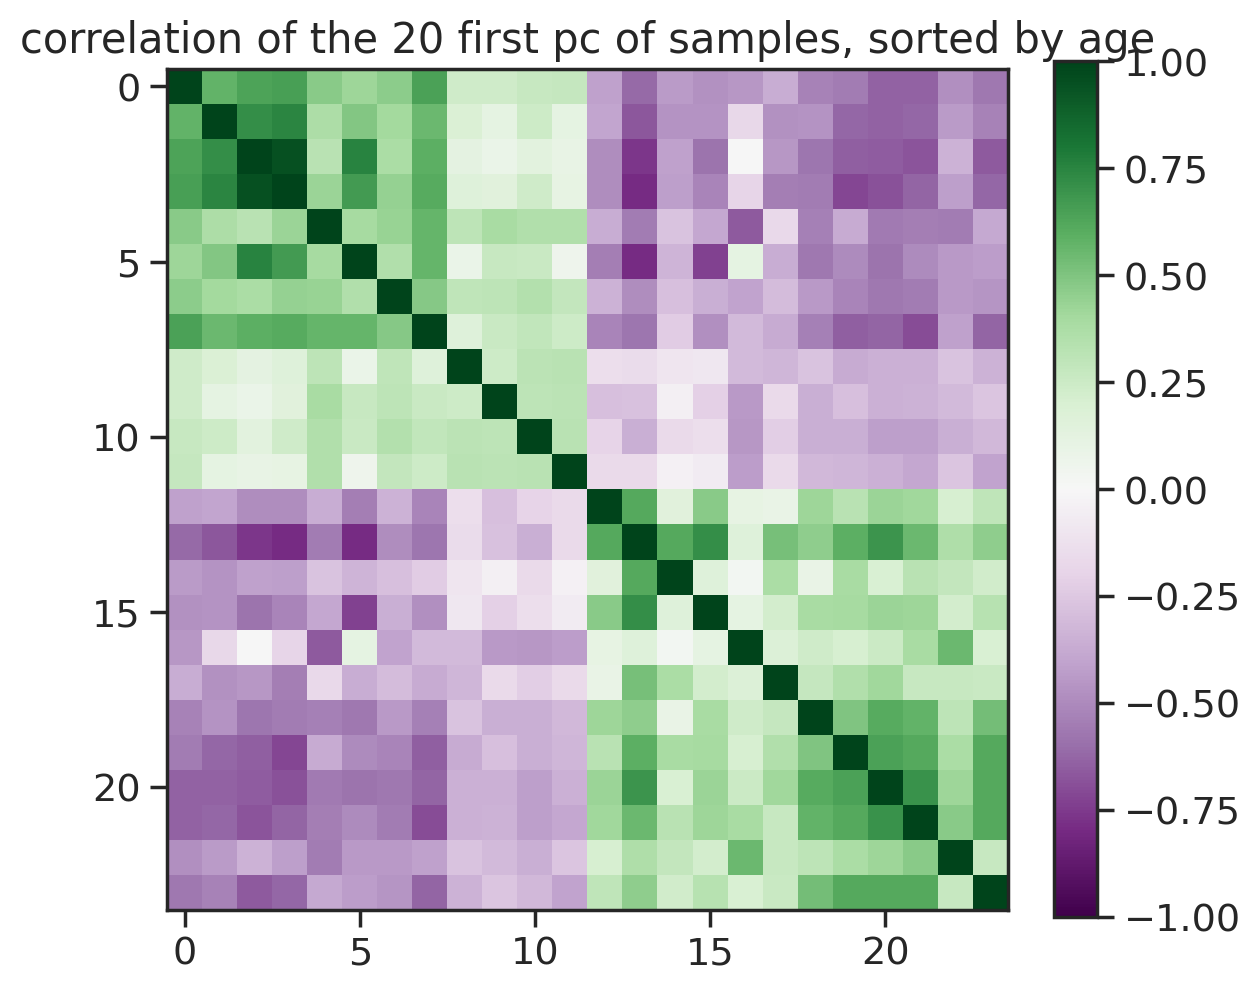

In [43]:
# plot the oc correlation between different mice, sorted by age order
dfd_pca_corr =(df_pca_dna).T.corr()

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(dfd_pca_corr, aspect="auto", 
               vmin=-1, 
               vmax=1, 
               cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title ('correlation of the 20 first pc of samples, sorted by age')
plt.colorbar(im, fraction=0.046)

In [44]:
# get behavioral data only for mice that are in the samples we have
fdata = fdata[fdata.mouse_id.isin(ids)]
behavior_meta = fdata[['age', 'mouse_id','uuid']].reset_index(drop=True)
behavior_meta.sort_index(inplace=True)
fdata.set_index(['age', 'mouse_id','uuid',], inplace=True)
fdata.drop(columns='mouse', inplace=True)
fdata.sort_index(inplace=True)

In [45]:
# PCA the data
pca = PCA(n_components=20).fit(fdata)
X_pca_behavior = pca.transform(fdata)
dfb_pca = pd.DataFrame(X_pca_behavior)
dfb_pca = dfb_pca.join(behavior_meta)
dfb_pca.set_index(['age','mouse_id','uuid'], inplace=True)
dfb_pca.sort_index(inplace=True)

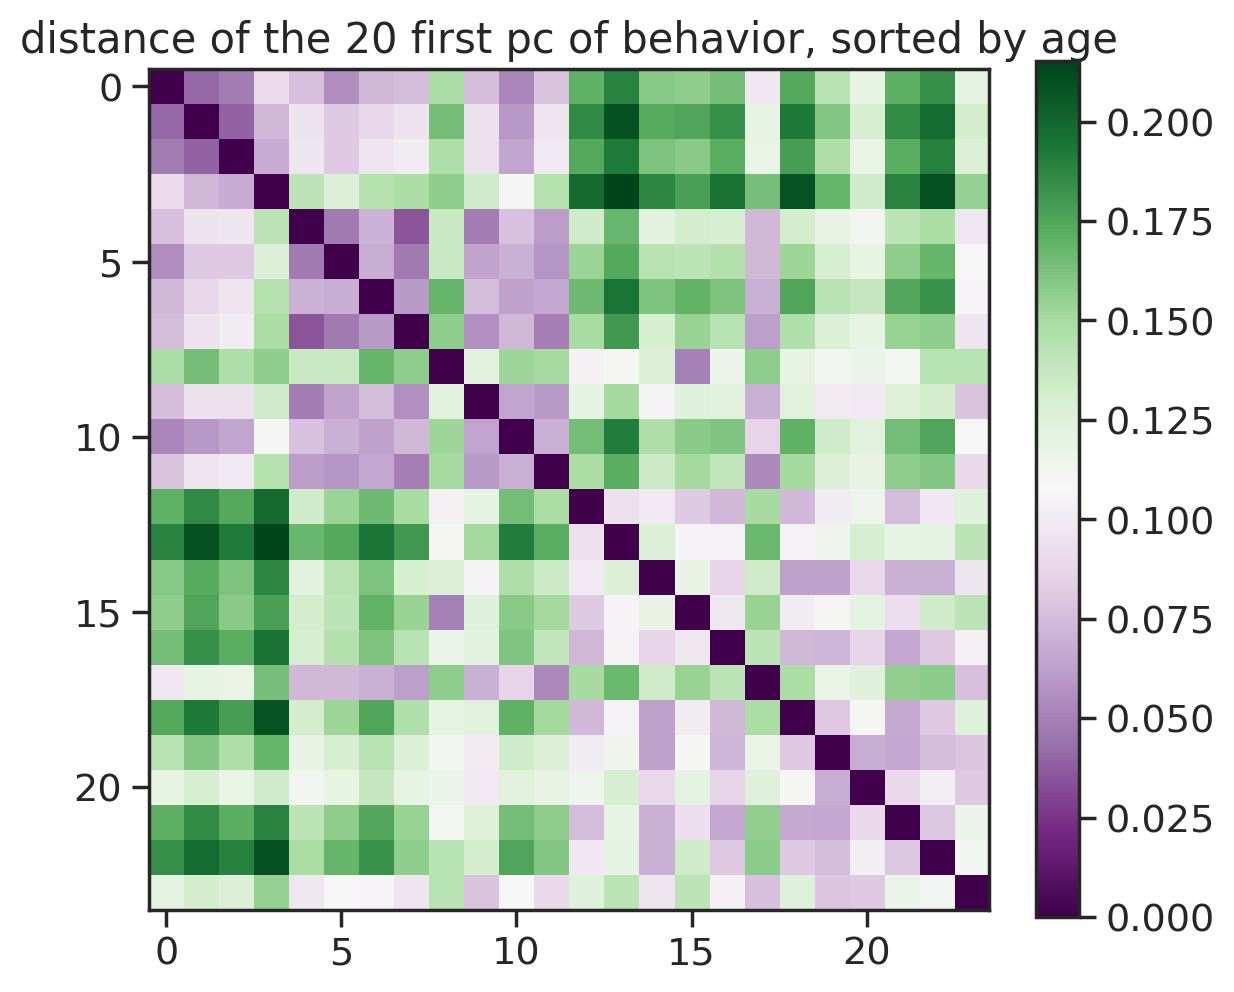

In [46]:
# plot the oc correlation between different mice, sorted by age order
dfb_pca_corr = pairwise_distances(dfb_pca)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(dfb_pca_corr, aspect="auto", 
               #vmin=-1, 
               #vmax=1, 
               cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title ('distance of the 20 first pc of behavior, sorted by age')
plt.colorbar(im, fraction=0.046)

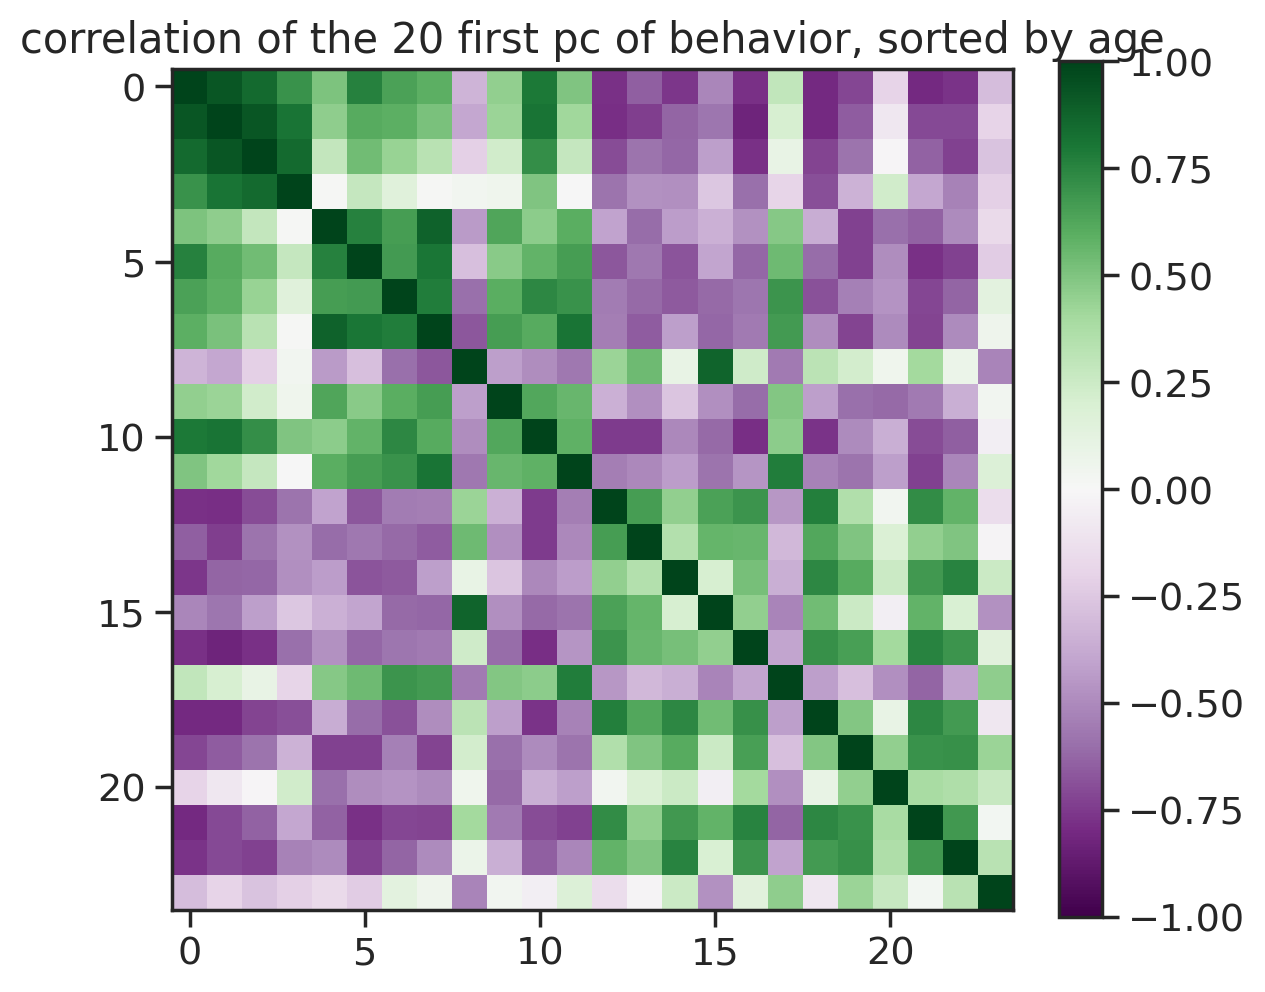

In [47]:
# plot the oc correlation between different mice, sorted by age order
dfb_pca_corr = dfb_pca.T.corr()
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(dfb_pca_corr, aspect="auto", 
               vmin=-1, 
                vmax=1, 
               cmap="PRGn")
ax.set_box_aspect(1)
ax. set_title ('correlation of the 20 first pc of behavior, sorted by age')
plt.colorbar(im, fraction=0.046)

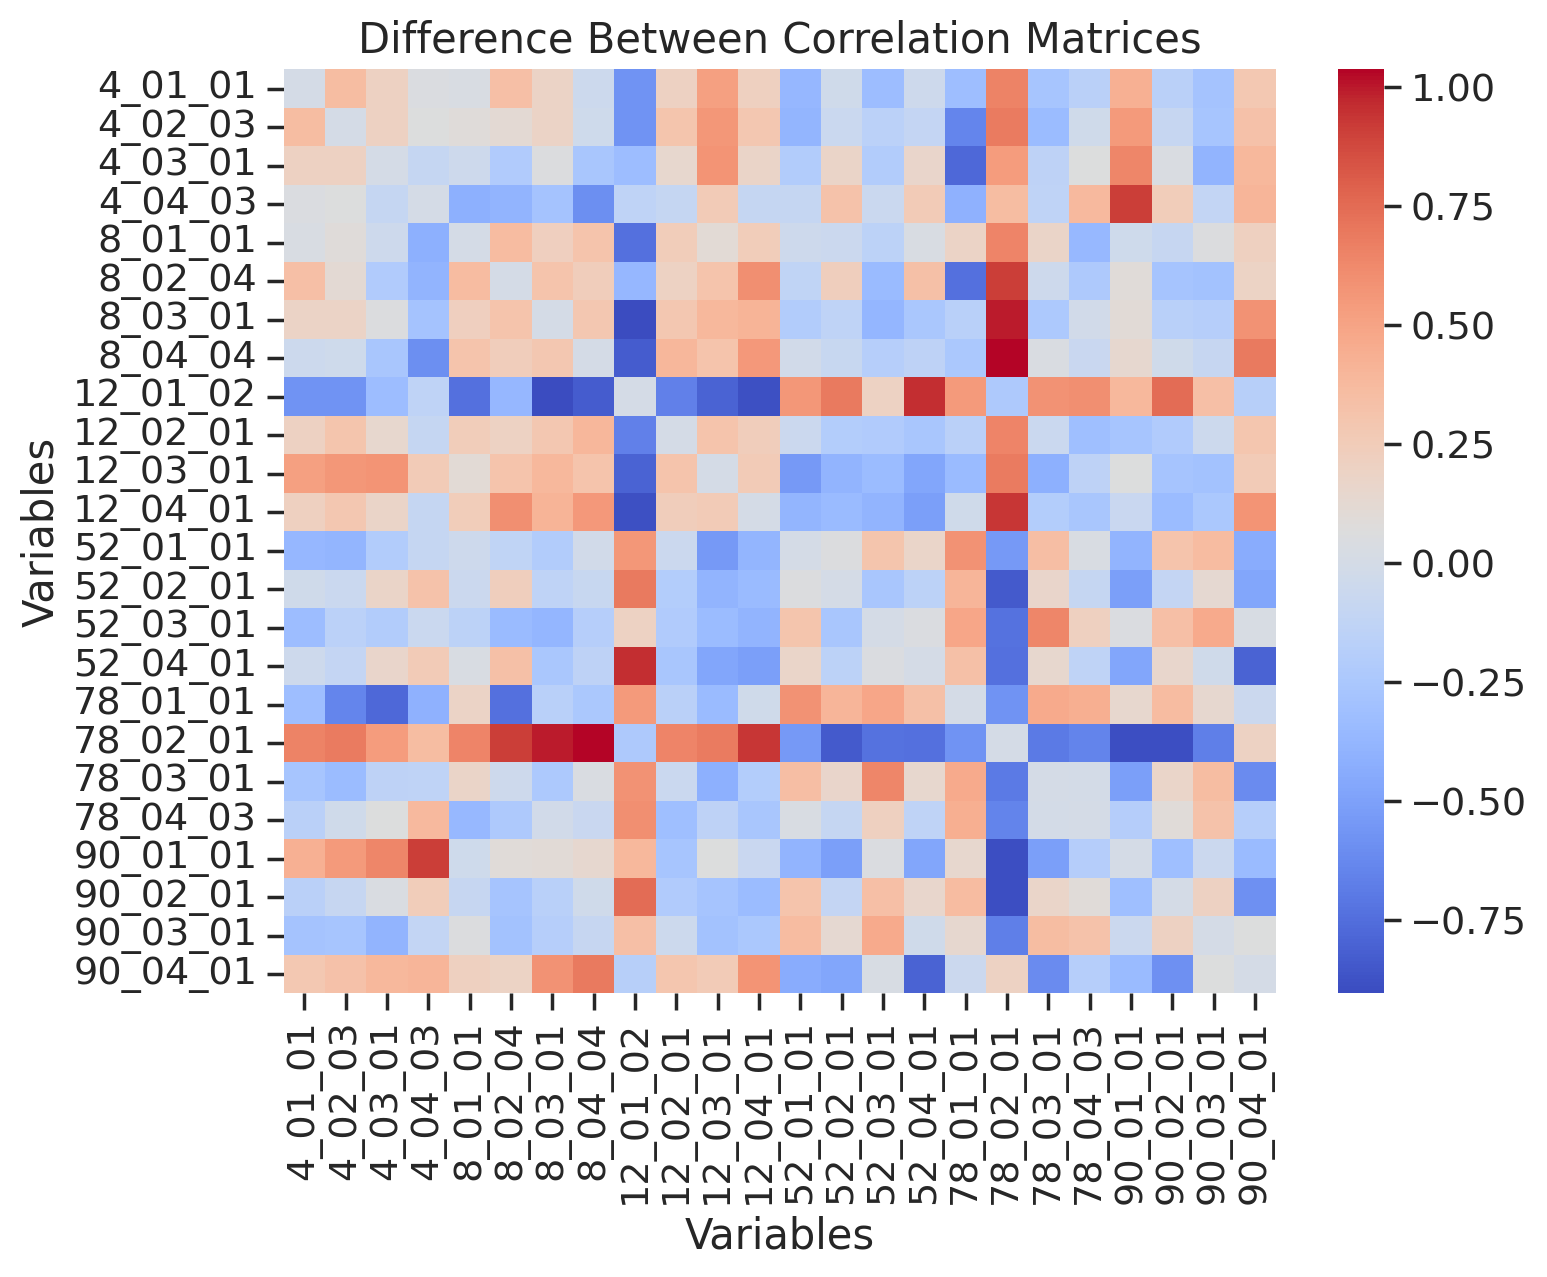

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(dfb_pca_corr-dfd_pca_corr, annot=False, cmap='coolwarm', 
            #fmt='.2f', 
            #linewidths=.5.
            xticklabels=dfb_pca_corr.index.get_level_values('mouse_id').values,
            yticklabels=dfb_pca_corr.index.get_level_values('mouse_id').values,
           )
plt.title('Difference Between Correlation Matrices')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.show()

0.7453910368403126


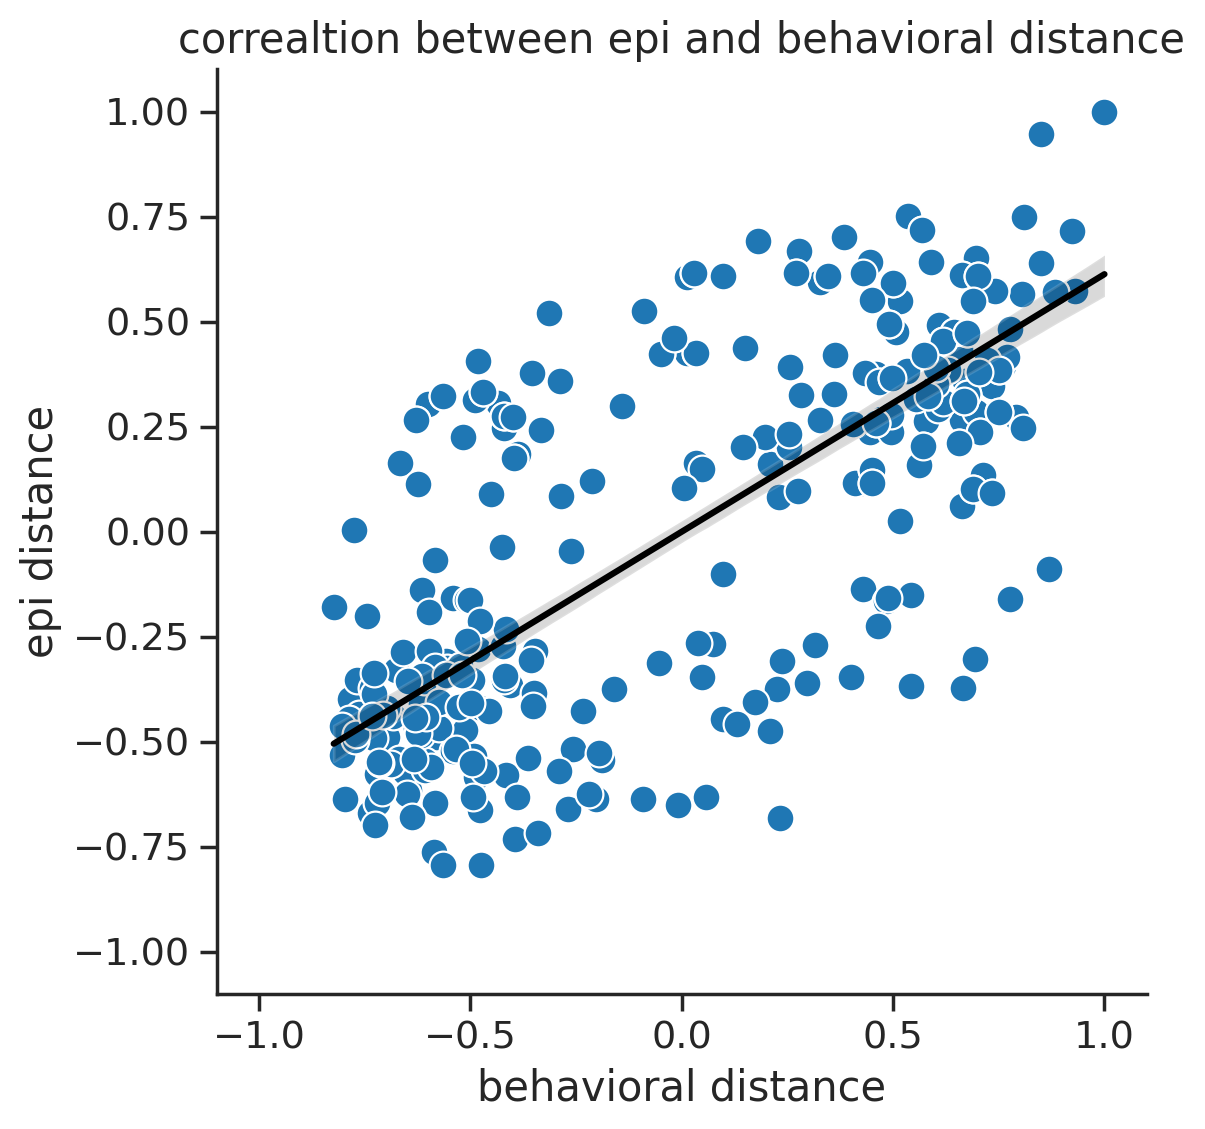

In [49]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=dfb_pca_corr.to_numpy().flatten(),y=dfd_pca_corr.to_numpy().flatten(),s=100)
[cm,pm] = stats.pearsonr(dfb_pca_corr.to_numpy().flatten(), dfd_pca_corr.to_numpy().flatten())
print(cm)
ax.set_ylim([-1.1,1.1])
ax.set_xlim([-1.1,1.1])
ax.set_title('correaltion between epi and behavioral distance')
ax.set_ylabel('epi distance')
ax.set_xlabel('behavioral distance')
sns.despine()

ax = sns.regplot(x=dfb_pca_corr.to_numpy().flatten(),y=dfd_pca_corr.to_numpy().flatten(),
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )


In [50]:
from scipy.spatial.distance import squareform

In [51]:
arr = dfb_pca_corr.to_numpy()
arr[np.diag_indices_from(arr)] = 0
b = squareform(arr)

In [52]:
arr = dfd_pca_corr.to_numpy()
arr[np.diag_indices_from(arr)] = 0
d = squareform(arr)

0.7001023383008929


Text(0.5, 1.0, 'correaltion between epi and behavioral distance. r=0.700')

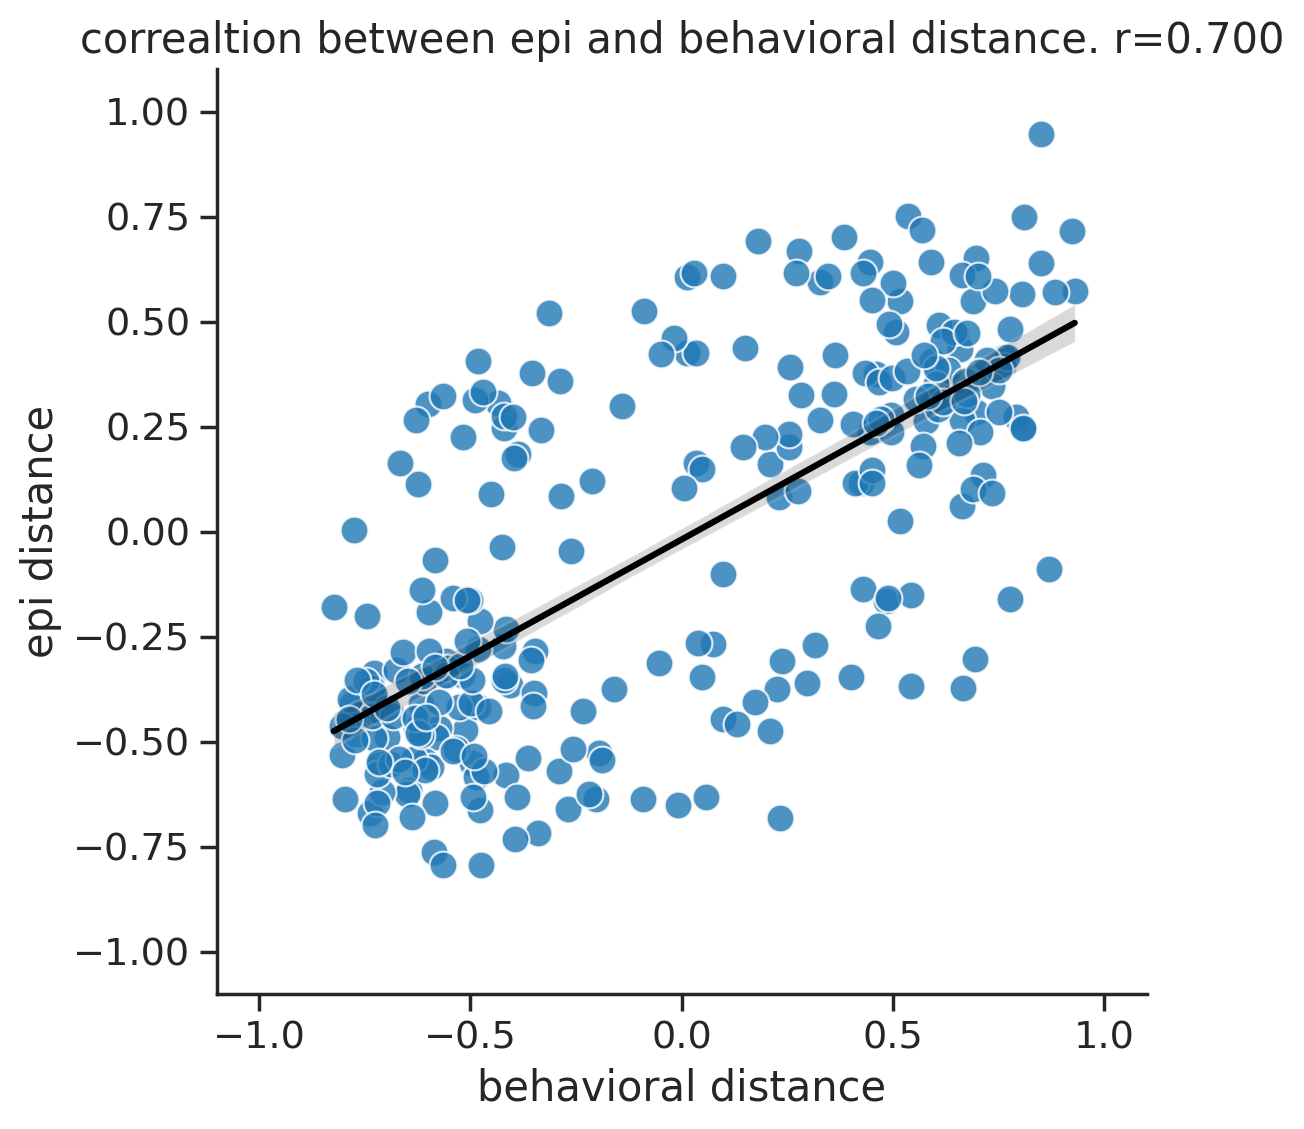

In [53]:
# b = np.triu(dfb_pca_corr.to_numpy(),k=1).flatten()
# d = np.triu(dfd_pca_corr.to_numpy(),k=1).flatten()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=b,y=d,s=100, alpha=0.8)
[cm,pm] = stats.pearsonr(b, d)
print(cm)
ax.set_ylim([-1.1,1.1])
ax.set_xlim([-1.1,1.1])
ax.set_ylabel('epi distance')
ax.set_xlabel('behavioral distance')
sns.despine()

ax = sns.regplot(x=dfb_pca_corr.to_numpy().flatten(),y=dfd_pca_corr.to_numpy().flatten(),
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and behavioral distance. r=' + f"{cm:.3f}")



In [54]:
### same as above but shuffle the ids within age for the epi data - to get whether the relationship
## represents between or within age variance

In [55]:
arr = dfb_pca_corr.to_numpy()[:12, :12]
arr[np.diag_indices_from(arr)] = 0
b = squareform(arr)

In [56]:
arr = dfd_pca_corr.to_numpy()[:12, :12]
arr[np.diag_indices_from(arr)] = 0
d = squareform(arr)

0.40975307868634153


Text(0.5, 1.0, 'correaltion between epi and behavioral distance young mice. r=0.410')

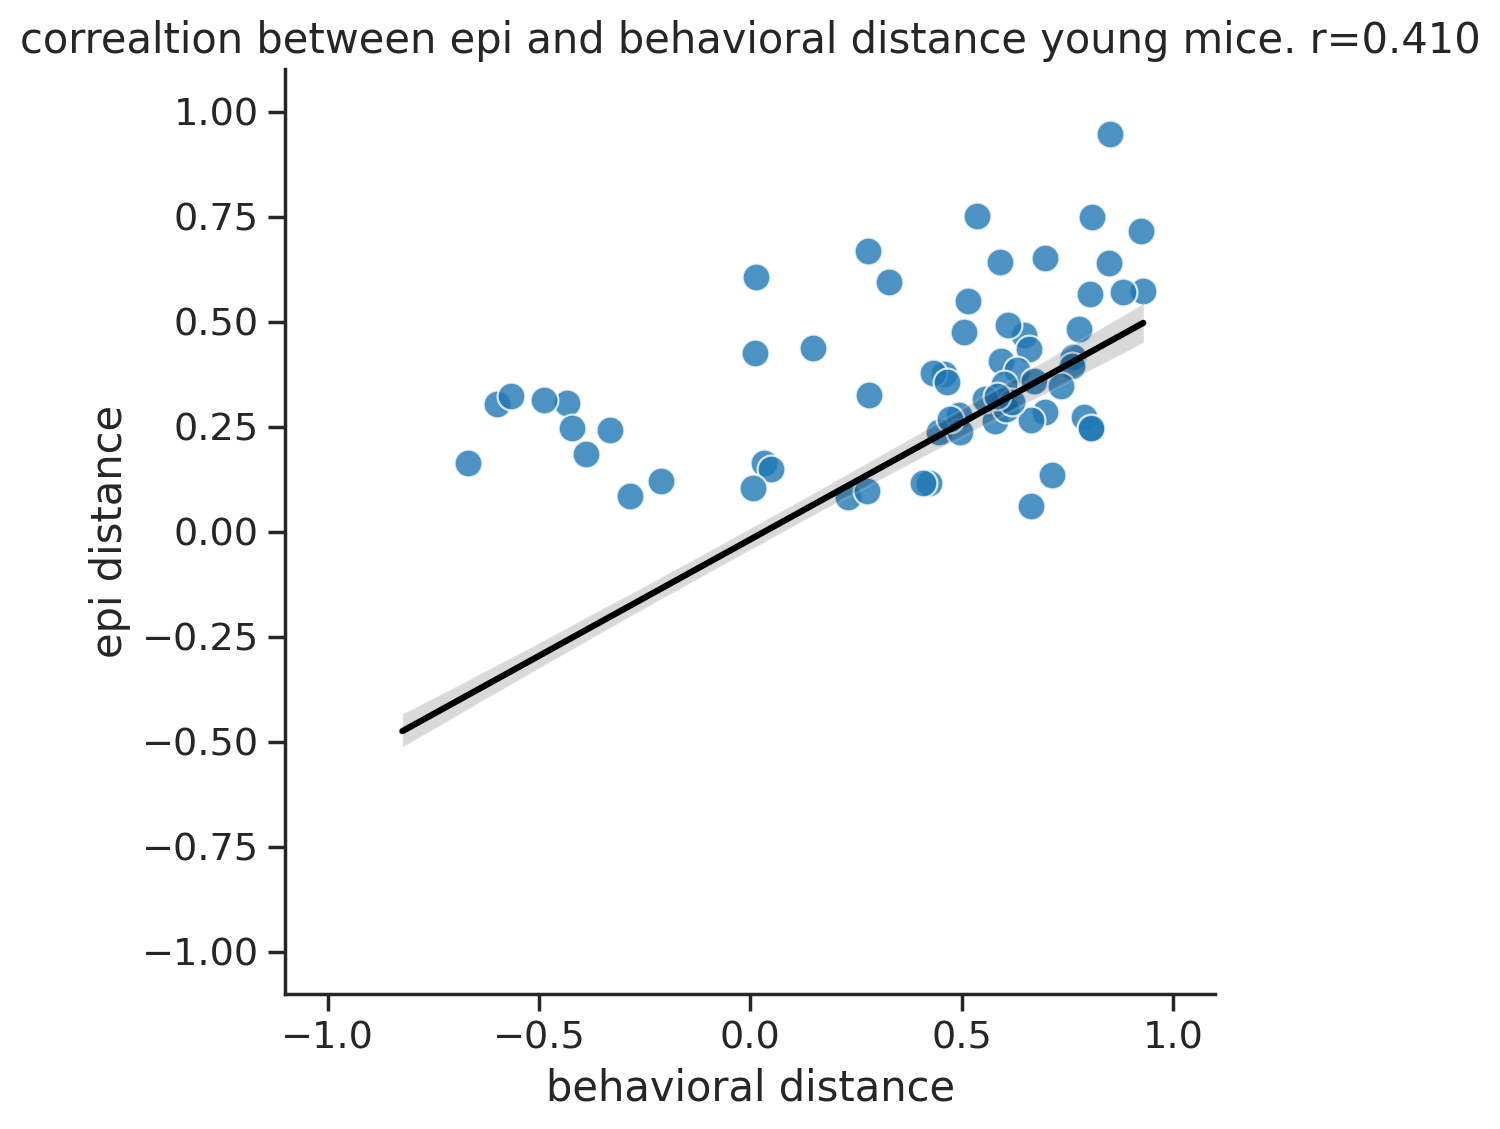

In [57]:
# b = np.triu(dfb_pca_corr.to_numpy(),k=1).flatten()
# d = np.triu(dfd_pca_corr.to_numpy(),k=1).flatten()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=b,y=d,s=100, alpha=0.8)
[cm,pm] = stats.pearsonr(b, d)
print(cm)
ax.set_ylim([-1.1,1.1])
ax.set_xlim([-1.1,1.1])
ax.set_ylabel('epi distance')
ax.set_xlabel('behavioral distance')
sns.despine()

ax = sns.regplot(x=dfb_pca_corr.to_numpy().flatten(),y=dfd_pca_corr.to_numpy().flatten(),
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and behavioral distance young mice. r=' + f"{cm:.3f}")



In [58]:
arr = dfb_pca_corr.to_numpy()[12:, 12:]
arr[np.diag_indices_from(arr)] = 0
b = squareform(arr)

In [59]:
arr = dfd_pca_corr.to_numpy()[12:, 12:]
arr[np.diag_indices_from(arr)] = 0
d = squareform(arr)

0.1219164543694112


Text(0.5, 1.0, 'correaltion between epi and behavioral distance - old mice. r=0.122')

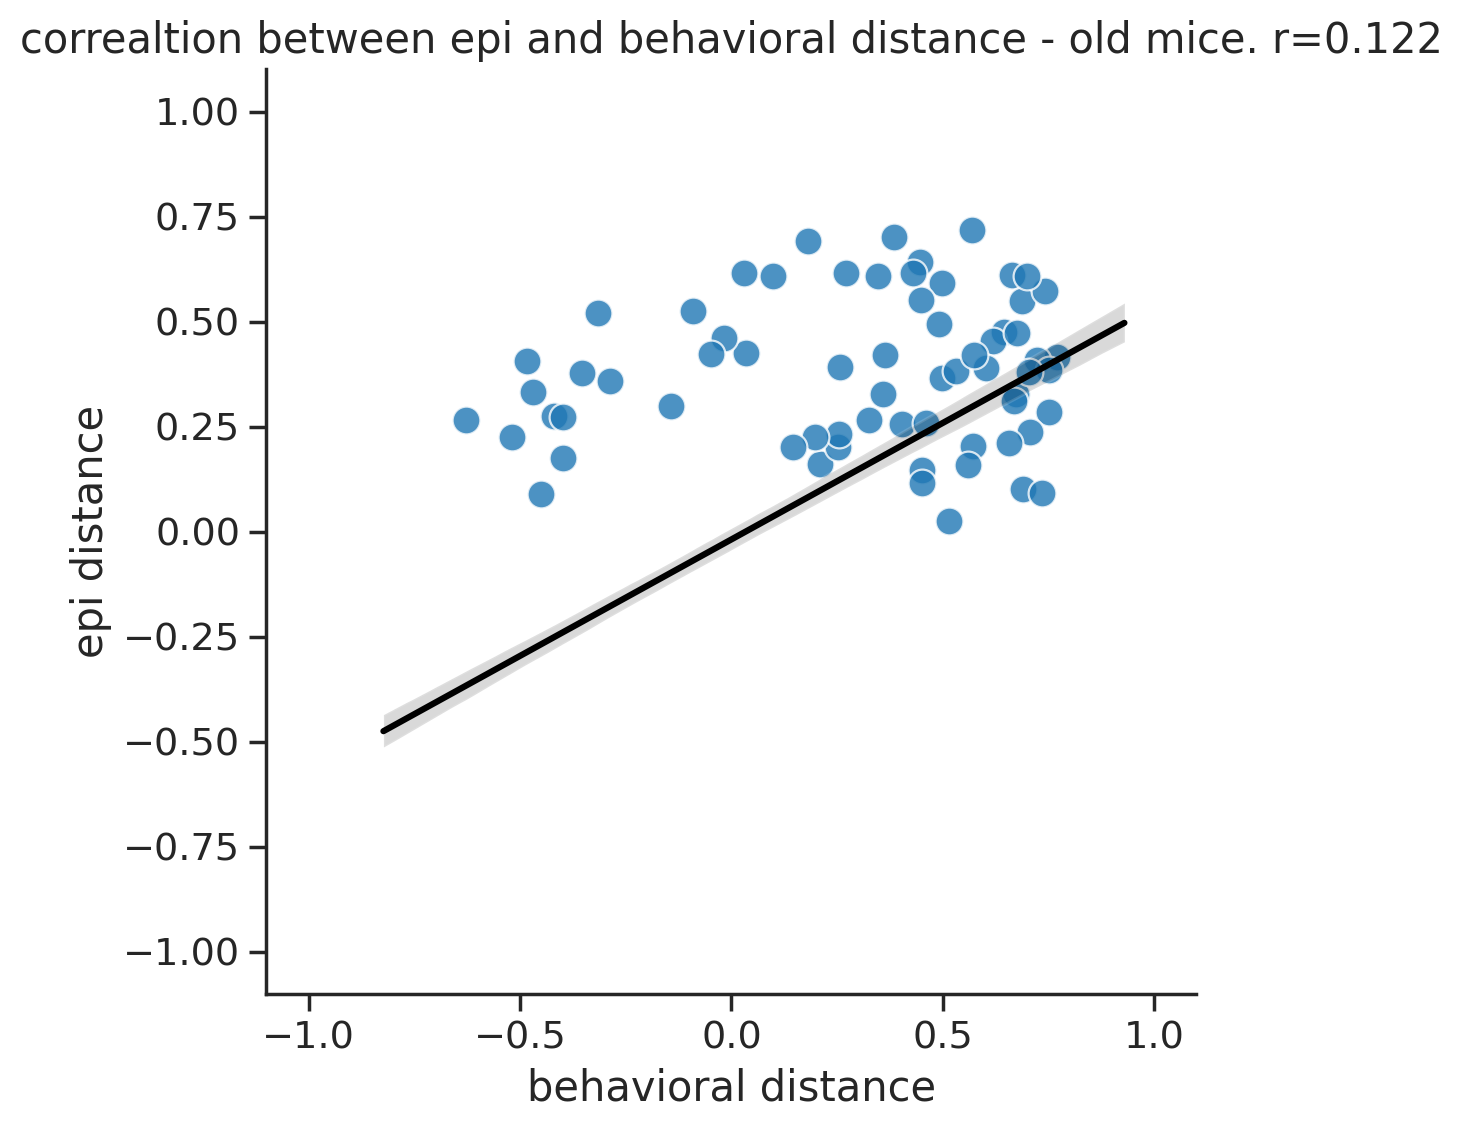

In [60]:
# b = np.triu(dfb_pca_corr.to_numpy(),k=1).flatten()
# d = np.triu(dfd_pca_corr.to_numpy(),k=1).flatten()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=b,y=d,s=100, alpha=0.8)
[cm,pm] = stats.pearsonr(b, d)
print(cm)
ax.set_ylim([-1.1,1.1])
ax.set_xlim([-1.1,1.1])
ax.set_ylabel('epi distance')
ax.set_xlabel('behavioral distance')
sns.despine()

ax = sns.regplot(x=dfb_pca_corr.to_numpy().flatten(),y=dfd_pca_corr.to_numpy().flatten(),
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and behavioral distance - old mice. r=' + f"{cm:.3f}")



In [61]:
ages = dfb_pca_corr.index.get_level_values('age').unique()

[0.92960201 0.84907842 0.69603431 0.92342333 0.80895387 0.84988671]
[0.57184443 0.64012438 0.65128082 0.71482125 0.74812613 0.94740316]
[0.76107482 0.65918443 0.88189988 0.67114345 0.8042011  0.77710555]
[0.39335047 0.43343836 0.56916606 0.35744319 0.565758   0.48229785]
[-0.42092269 -0.48803025 -0.56532602  0.61796709  0.55487828  0.58257815]
[0.24604097 0.31252792 0.32231232 0.3077965  0.31501829 0.32291696]
[0.66329756 0.45120399 0.64460926 0.34630838 0.56825343 0.20970178]
[0.60959827 0.14717111 0.47421795 0.60944036 0.7186556  0.16159345]
[-0.39777956  0.70562172  0.65560286 -0.4202362  -0.28754479  0.49099549]
[0.17617573 0.23685092 0.21011578 0.27601173 0.35824935 0.49367632]
[0.38397018 0.36239038 0.27120982 0.67572338 0.02937545 0.32649687]
[0.70077328 0.42021388 0.61530751 0.47160291 0.61481534 0.26658217]


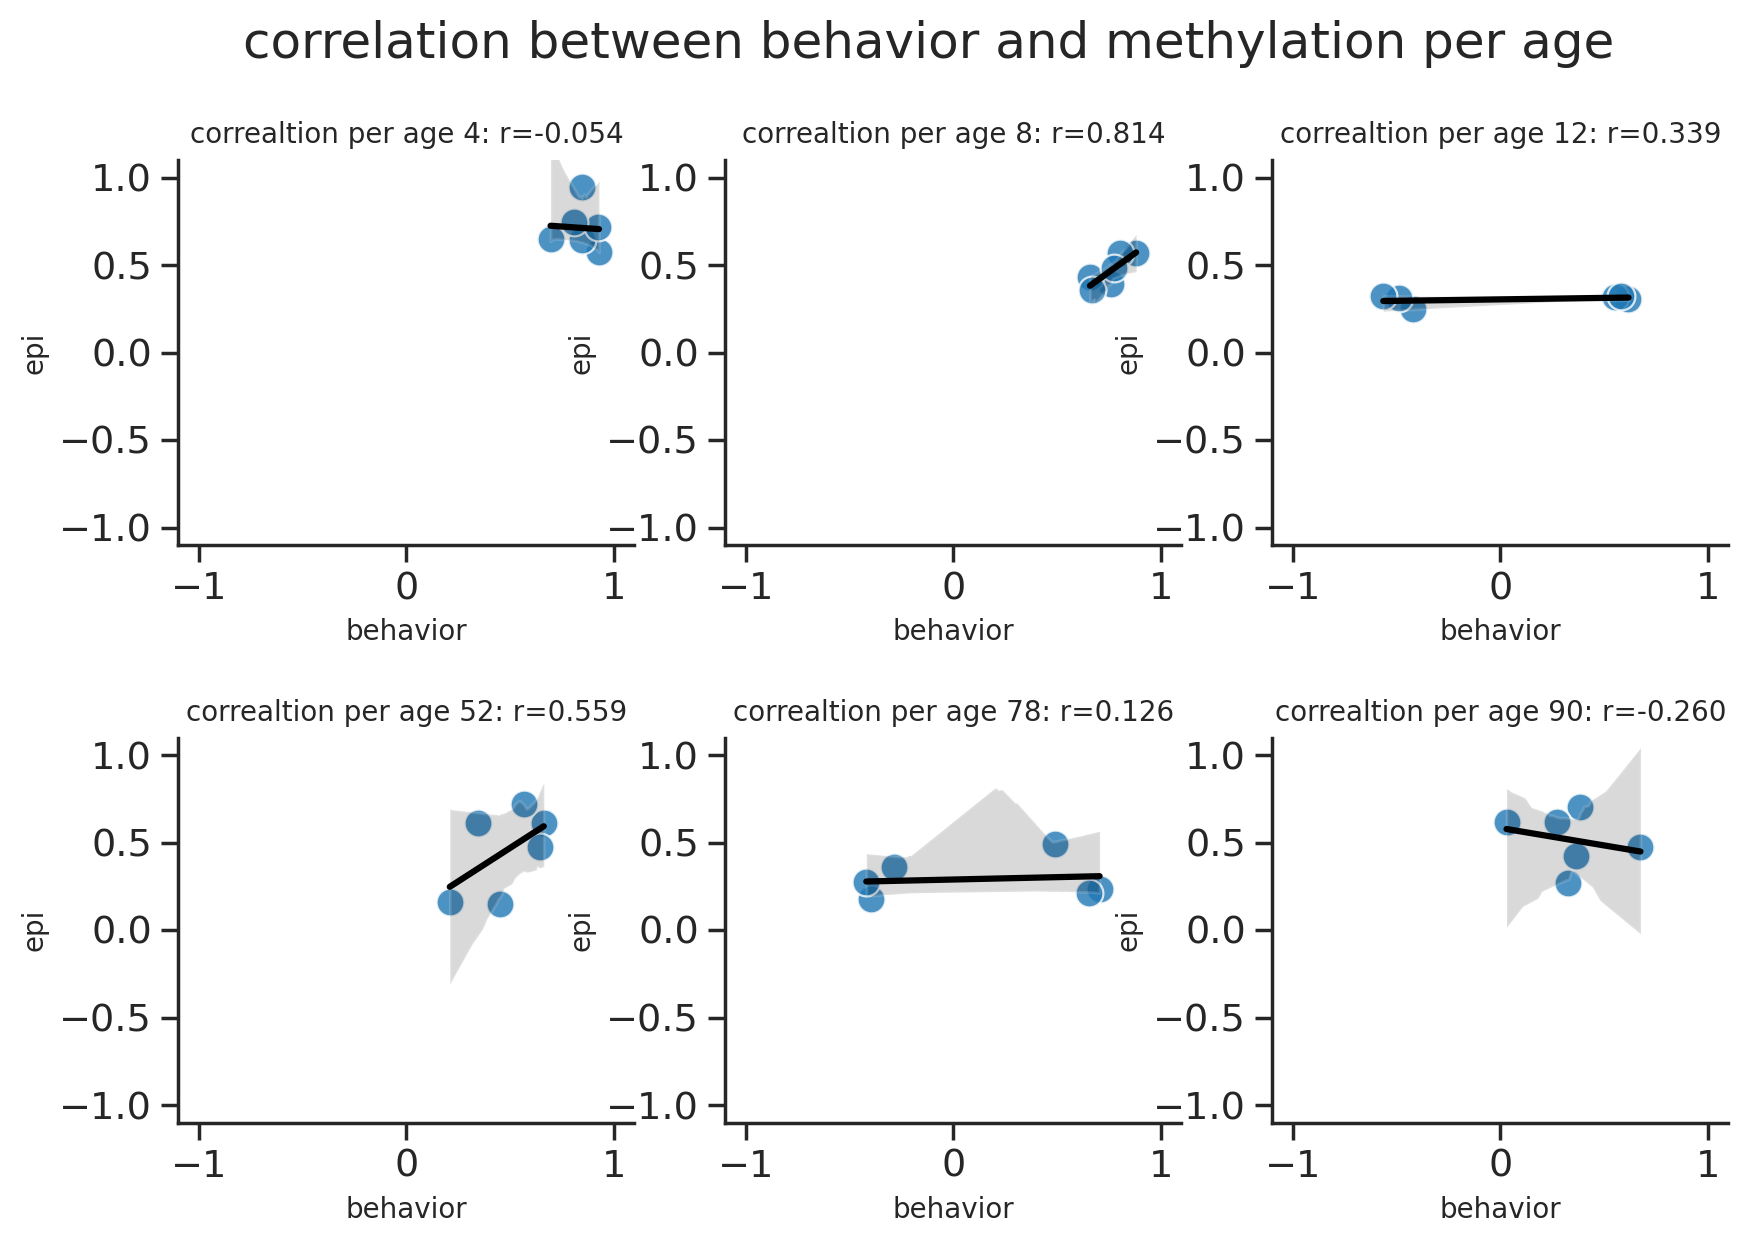

In [62]:
#per age
n=0
fig=plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("correlation between behavior and methylation per age", fontsize=18, y=0.95)
for age in ages:
    # behavior
    arr = dfb_pca_corr.loc[dfb_pca_corr.index.get_level_values('age') == age][age].to_numpy()
    arr[np.diag_indices_from(arr)] = 0
    b = squareform(arr)
    print(b)
    #methylation
    arr = dfd_pca_corr.loc[dfd_pca_corr.index.get_level_values('age_cat') == age][age].to_numpy()
    arr[np.diag_indices_from(arr)] = 0
    d = squareform(arr)
    print(d)
    # plot
    ax = plt.subplot(3, 3, n + 1)
    ax=sns.scatterplot(x=b,y=d,s=100, alpha=0.8)
    [cm,pm] = stats.pearsonr(b, d)
    ax.set_title('correaltion per age ' + str(age) +': r=' + f"{cm:.3f}", fontsize=10)
    ax.set_ylabel('epi',fontsize=10)
    ax.set_xlabel('behavior',fontsize=10)
    ax.set_ylim([-1.1,1.1])
    ax.set_xlim([-1.1,1.1])
    ax = sns.regplot(x=b,y=d,
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
    sns.despine()
    n=n+1

In [63]:
## rank order of mice in epiclock vs behavioral clock

In [64]:
# get dataframe of epi data with uuids of beahvioral data
temp = pd.merge(df_pca_dna, dfb_pca, left_index=True, right_index=True, how='inner')
df_pca_dna['uuid'] = temp.index.get_level_values('uuid')
df_pca_dna.set_index('uuid',append='True', inplace=True)

In [65]:
# epiclock age prediction per mouse id
temp = df_age_pred.join(df_meta_merge).reset_index()
epi=temp[['mouse_id','age','weeks','rc']].sort_values(by='age').reset_index(drop=True)
epi['epi_rank'] = epi['weeks'].rank()

In [66]:
## get behavioral clock

In [67]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid','mouse']).mean()
data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid','mouse']).mean()


data_all = pd.concat([data,data_dana])
m_data = data_all.query('age<100')

In [68]:
#filter to find ages in age range of the epidata
beh_data = m_data.reset_index()
beh_data['mouse']=beh_data['mouse'].str[-6:]
beh_data['mouse_id'] = [x + y for x, y in zip(beh_data['age'].astype(str), beh_data['mouse'])]
beh_data.set_index(['age','mouse_id','mouse','uuid'],append=True,inplace=True)

In [69]:
ids = df_pca_dna.index.get_level_values('mouse_id')

In [70]:
x_test = beh_data[beh_data.index.get_level_values('mouse_id').isin(ids)]
len(x_test)

24

In [71]:
x_train = beh_data[~beh_data.index.get_level_values('mouse_id').isin(ids)]
## choose 16 mice for each age group
#n=16
x_train = x_train.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
print(len(x_train))
y = x_train.index.get_level_values('age')

156


In [72]:
# choose a model for decoder
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=10)
clf.fit(x_train.to_numpy(),y)

KNeighborsRegressor(n_neighbors=10)

In [73]:
y_test = clf.predict(x_test.to_numpy())
print(y_test)
x_test['behavioral_age'] = y_test
x_test['behavioral_rank'] = x_test['behavioral_age'].rank()

[ 4.5  4.6  4.4  5.2  9.7  8.1  9.5 10.8 19.3 13.8 10.9 43.5 45.2 47.6
 71.8 49.2 59.6 65.  62.2 17.1 55.8 69.6 70.8 61.8]


/tmp/ipykernel_928/1156360991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['behavioral_age'] = y_test
/tmp/ipykernel_928/1156360991.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['behavioral_rank'] = x_test['behavioral_age'].rank()


In [74]:
temp = x_test.reset_index()
beh = temp[['mouse_id','age','behavioral_age','behavioral_rank']]

In [75]:
age_pred = pd.merge(epi,beh,on='mouse_id', suffixes=('_epi', '_age'))

Text(0.5, 1.0, 'correaltion between epi and behavioral predicted ages. r=0.849')

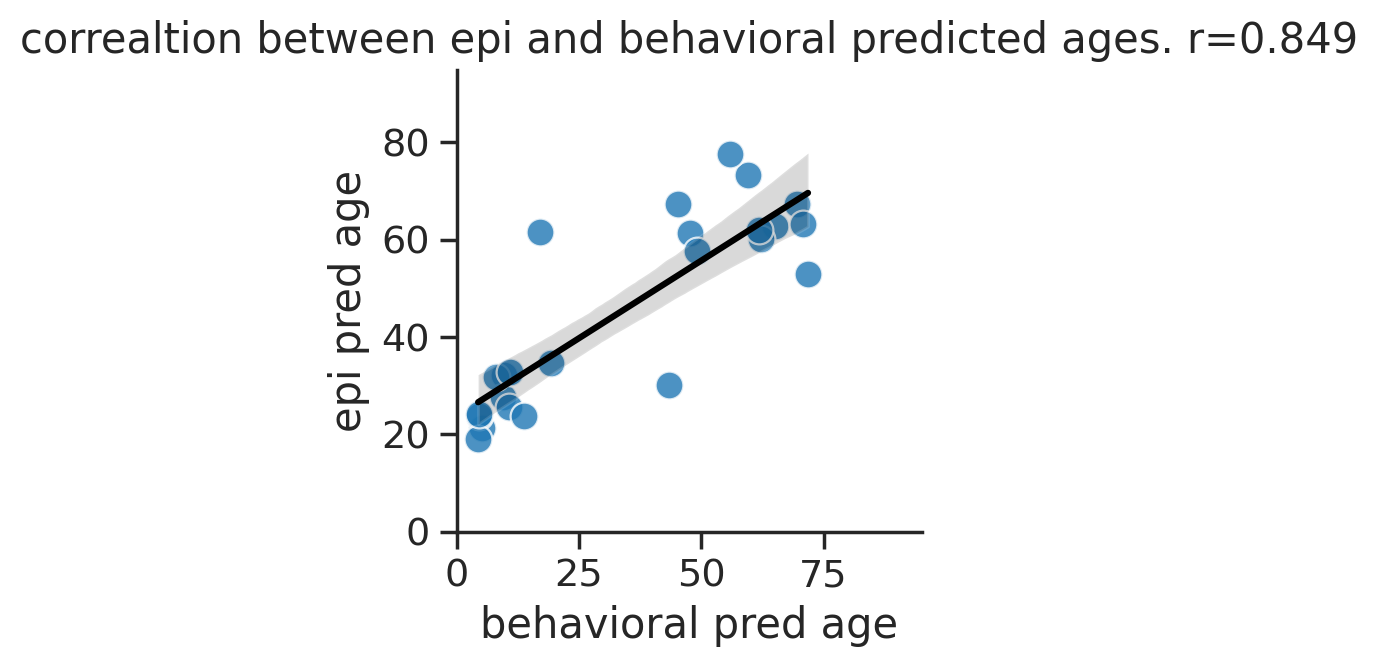

In [76]:
b = age_pred.behavioral_age.to_numpy()
d= age_pred.weeks.to_numpy()
fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x=b,y=d,s=100, alpha=0.8)
[cm,pm] = stats.pearsonr(b, d)
ax.set_ylim([0,95])
ax.set_xlim([0,95])
ax.set_ylabel('epi pred age')
ax.set_xlabel('behavioral pred age')
sns.despine()

ax = sns.regplot(x=b,y=d,
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and behavioral predicted ages. r=' + f"{cm:.3f}")

In [78]:
from aging.plotting import figure, save_factory, PlotConfig, format_plots, ONTOGENY_AGE_CMAP, add_identity, legend
c = PlotConfig()
fig.savefig(c.dana_save_path / "simons"/ 'epi_age_vs_beh_age.pdf')

Text(0.5, 1.0, 'correaltion between epi and behavioral ranking of predicted ages. r=0.807')

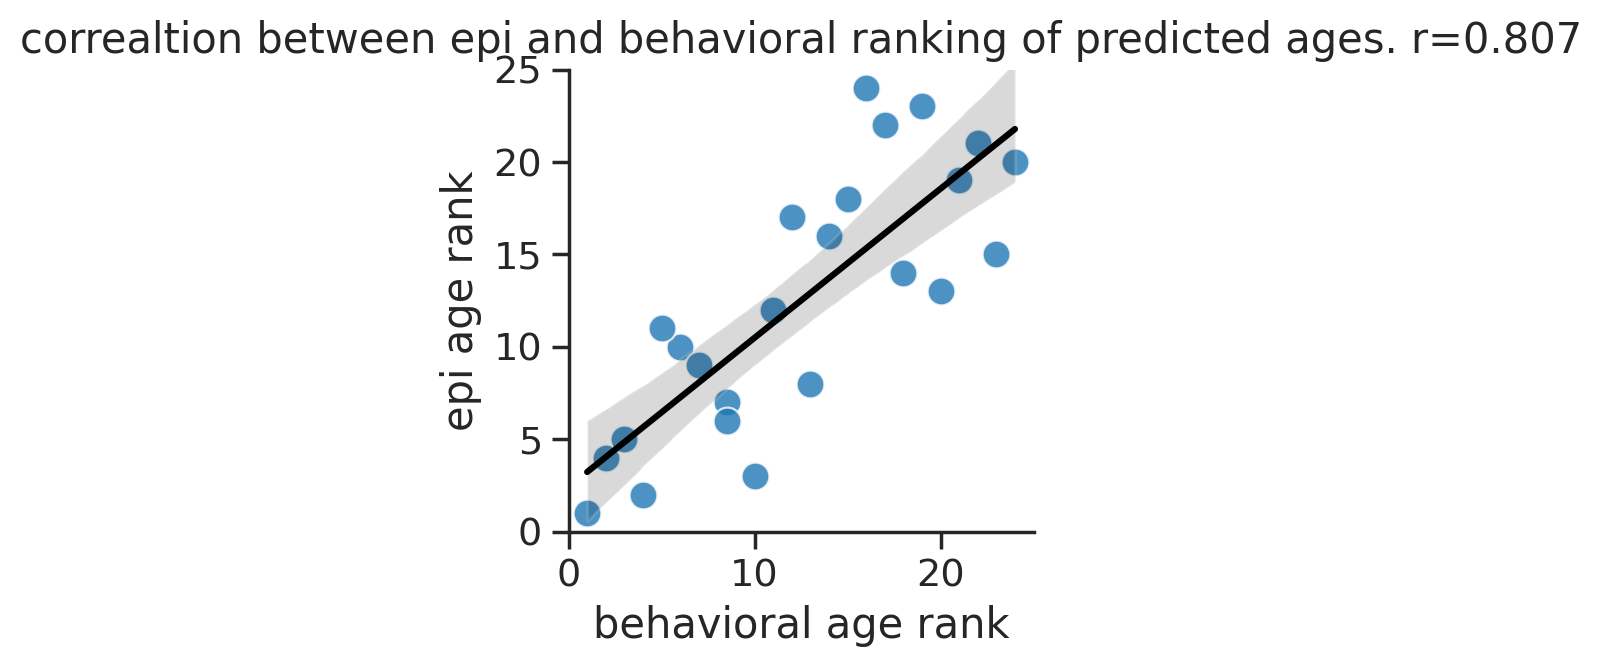

In [79]:
b = age_pred.behavioral_rank.to_numpy()
d= age_pred.epi_rank.to_numpy()
fig, ax = plt.subplots(figsize=(3,3))
sns.scatterplot(x=b,y=d,s=100, alpha=0.8)
[cm,pm] = stats.pearsonr(b, d)
ax.set_ylim([0,25])
ax.set_xlim([0,25])
ax.set_ylabel('epi age rank')
ax.set_xlabel('behavioral age rank')
sns.despine()

ax = sns.regplot(x=b,y=d,
                 scatter=False, 
                 color='black',
                 logx=False,
                 fit_reg=True,
                )
ax.set_title('correaltion between epi and behavioral ranking of predicted ages. r=' + f"{cm:.3f}")

In [80]:
fig.savefig(c.dana_save_path / "simons"/ 'epi_rank_vs_beh_rank.pdf')